In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from tqdm import notebook
from matplotlib import gridspec
from matplotlib import rc
import pandas as pd
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

#import models
from models import ScoreNet_2D
from models import MLP, get_timestep_embedding

#import training fns
from training import loss_fn, train_model, CDE_loss_fn_2D

#import SDE functions
from SDE import marginal_prob_std_fn_2D as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_2D as diffusion_coeff_fn

#import sampling functions
from sampling import Euler_Maruyama_sampler_2D as Euler_Maruyama_sampler
from sampling import pc_sampler_2D as pc_sampler
from sampling import ode_sampler_2D as ode_sampler
from sampling import CDE_Euler_Maruyama_sampler_2D as CDE_Euler_Maruyama_sampler
from sampling import CDE_pc_sampler_2D as CDE_pc_sampler
from sampling import CDiffE_Euler_Maruyama_sampler_2D as CDiffE_Euler_Maruyama_sampler
from sampling import CDiffE_pc_sampler_2D as CDiffE_pc_sampler
from sampling import SMCDiff_Euler_Maruyama_sampler_2D as SMCDiff_Euler_Maruyama_sampler
from sampling import SMCDiff_pc_sampler_2D as SMCDiff_pc_sampler
from sampling import sde_VE

# Simple diffusion plot

#### Train model on moons dataset. Get visualisations of forward process by sampling from marginal_prob_std_fn for different t. Get visualisations of the reverse process by sampling from pc_sampler at different t.

In [2]:
moons = datasets.make_moons(n_samples=50000, noise=0.01)[0]

In [47]:
score_model = ScoreNet_2D(marginal_prob_std=marginal_prob_std_fn)

In [48]:
sum(p.numel() for p in score_model.parameters())

32210

In [87]:
losses = train_model(score_model, moons, loss_fn, marginal_prob_std_fn, 'moons_test.pth', epochs = 200, batch_size = 500)

  0%|          | 0/200 [00:00<?, ?it/s]

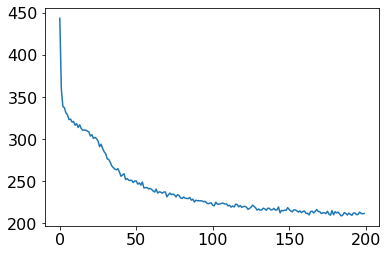

In [88]:
plt.plot(losses)

In [89]:
pc_samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

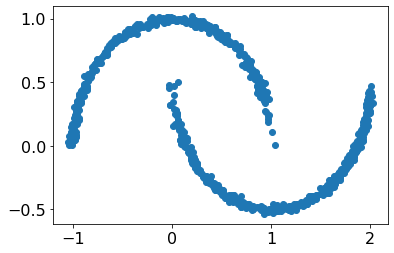

In [90]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

In [4]:
#Implimentation from shi et al - best model so far :)
class ScoreNet_2D(nn.Module):
    
    def __init__(self, marginal_prob_dist):
        super().__init__()
        self.marginal_prob_dist = marginal_prob_dist
        
        self.net = MLP(3 * 32,
                       layer_widths=[128,128] + [2],
                       activate_final = False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(16,
                             layer_widths=[16] + [32],
                             activate_final = True,
                             activation_fn=torch.nn.LeakyReLU())

        self.xy_encoder = MLP(2,
                              layer_widths=[32] + [64],
                              activate_final = True,
                              activation_fn=torch.nn.LeakyReLU())
        
    def forward(self, x):
        t = x[:, -1]
        _, norm = self.marginal_prob_dist(t)
        t = t.reshape(-1,1)
        xy = x[:,[0,1]]
        
        t_emb = get_timestep_embedding(t, 16, 10000)
        t_emb = self.t_encoder(t_emb)
        xy_emb = self.xy_encoder(xy)

        
        h = torch.cat([xy_emb, t_emb], -1)

        out = self.net(h) 

        out = out / norm[:,None]
        return out
    

In [5]:
def loss_fn(model, x, marginal_prob_dist_fn, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the mean and standard deviation of the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    mean_coeff, std = marginal_prob_dist_fn(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x * mean_coeff[:, None] + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [6]:
def marginal_prob_dist(t, beta_min, beta_max):
    t_squared = torch.pow(t, 2)
    mean_coeff = torch.exp(-1/4 * t_squared * (beta_max - beta_min) - 1/2 * t * beta_min)
    sd = torch.sqrt(1 - torch.exp(-1/2 * t_squared * (beta_max - beta_min) - t * beta_min))
    return mean_coeff, sd

def beta_t(t, beta_min, beta_max):
    return beta_min + t*(beta_max - beta_min)

beta_min = 0.1
beta_max = 20

marginal_prob_dist_fn = functools.partial(marginal_prob_dist, beta_min=beta_min, beta_max=beta_max)
beta_t_fn = functools.partial(beta_t, beta_min=beta_min, beta_max=beta_max)

In [7]:
score_model = ScoreNet_2D(marginal_prob_dist=marginal_prob_dist_fn)

In [9]:
losses = train_model(score_model, moons, loss_fn, marginal_prob_dist_fn, 'models/moons.pth', epochs = 100, batch_size = 64)





  0%|          | 0/100 [00:00<?, ?it/s]

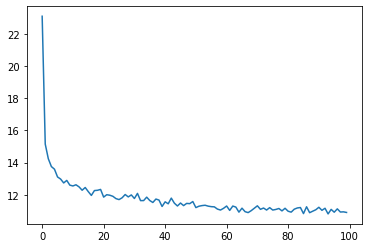

In [10]:
plt.plot(losses)

In [57]:
num_steps =  1000
signal_to_noise_ratio = 0.2
def pc_sampler(score_model, marginal_prob_dist, beta_t, 
               batch_size=1000, num_steps=num_steps, eps=1e-3, snr = signal_to_noise_ratio):
    
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    xs = [x]
    
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))

            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            b = beta_t(t=batch_time_step)[:,None]/num_steps
            alpha = 1 - b
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * alpha * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Predictor step
            b = beta_t(t=batch_time_step)[:,None]
            score = score_model(x_with_t)
            mean_x = x + (1/2 * b + b * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(b) * torch.randn_like(x)  
            xs.append(x)
    # Do not include any noise in the last sampling step.
    return mean_x, xs

In [58]:
#for sampling, will take samples at t=T, t=3T/4, t=T/2, t=T/4, t=eps
#can plot the scatter plot, and the density plot of the x variable to show convergence to normal dist
score_model = ScoreNet_2D(marginal_prob_dist=marginal_prob_dist_fn)
ckpt = torch.load('models/moons.pth')
score_model.load_state_dict(ckpt)
pc_samples, xs = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

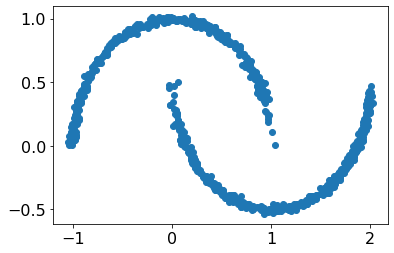

In [91]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

In [60]:
def get_diffused(data, t, marginal_prob_dist):
    data = torch.tensor(data)
    mean_coeff, sd = marginal_prob_dist(t)
    diffused = mean_coeff*data + torch.randn(data.shape[0], 2) * sd
    return diffused

In [93]:
idx = np.random.randint(50000, size=1000)
sample = moons[idx]

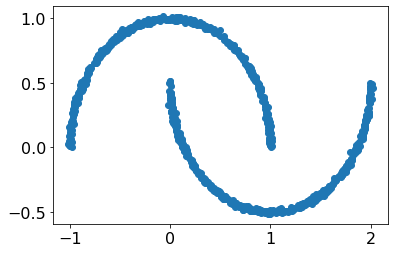

In [94]:
plt.scatter(sample[:,0], sample[:,1])

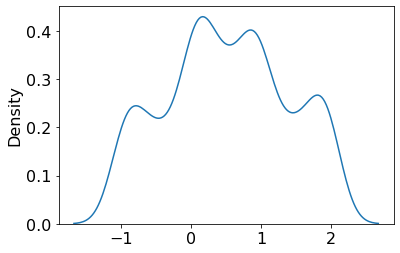

In [95]:
sns.kdeplot(sample[:,0])

In [96]:
np.mean(sample[:,0])

0.5180402076557494

In [97]:
np.var(sample[:,0])

0.7503256487211466

In [66]:
small_diff = get_diffused(sample, torch.tensor(0.1), marginal_prob_dist_fn)

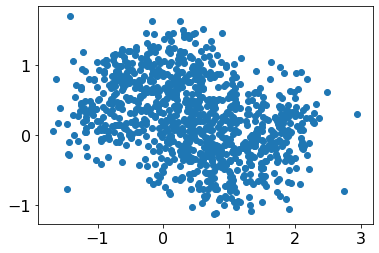

In [67]:
plt.scatter(small_diff[:,0], small_diff[:,1])

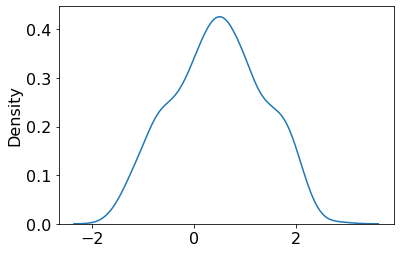

In [68]:
sns.kdeplot(small_diff[:,0])

In [69]:
torch.mean(small_diff[:,0])

tensor(0.4712, dtype=torch.float64)

In [70]:
torch.var(small_diff[:,0])

tensor(0.8023, dtype=torch.float64)

In [71]:
half_diff = get_diffused(sample, torch.tensor(0.5), marginal_prob_dist_fn)

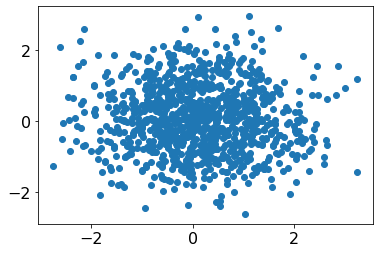

In [72]:
plt.scatter(half_diff[:,0], half_diff[:,1])

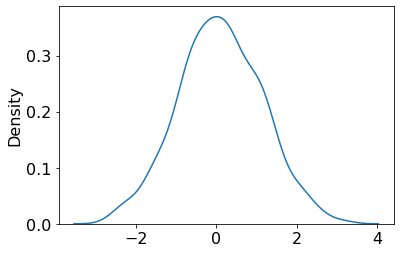

In [73]:
sns.kdeplot(half_diff[:,0])

In [74]:
torch.mean(half_diff[:,0])

tensor(0.1028, dtype=torch.float64)

In [75]:
torch.var(half_diff[:,0])

tensor(1.0868, dtype=torch.float64)

In [76]:
full_diff = get_diffused(sample, torch.tensor(1), marginal_prob_dist_fn)

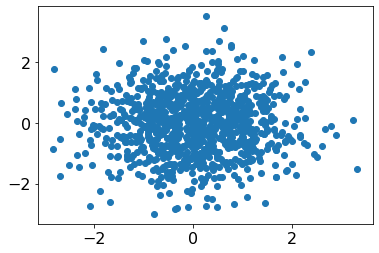

In [77]:
plt.scatter(full_diff[:,0], full_diff[:,1])

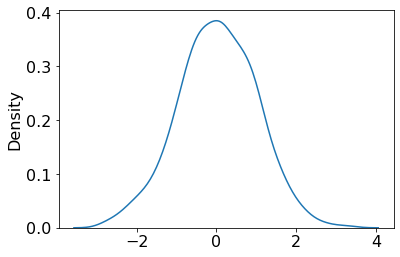

In [78]:
sns.kdeplot(full_diff[:,0])

In [79]:
torch.mean(full_diff[:,0])

tensor(0.0301, dtype=torch.float64)

In [80]:
torch.var(full_diff[:,0])

tensor(0.9809, dtype=torch.float64)

NameError: name 'xs' is not defined

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


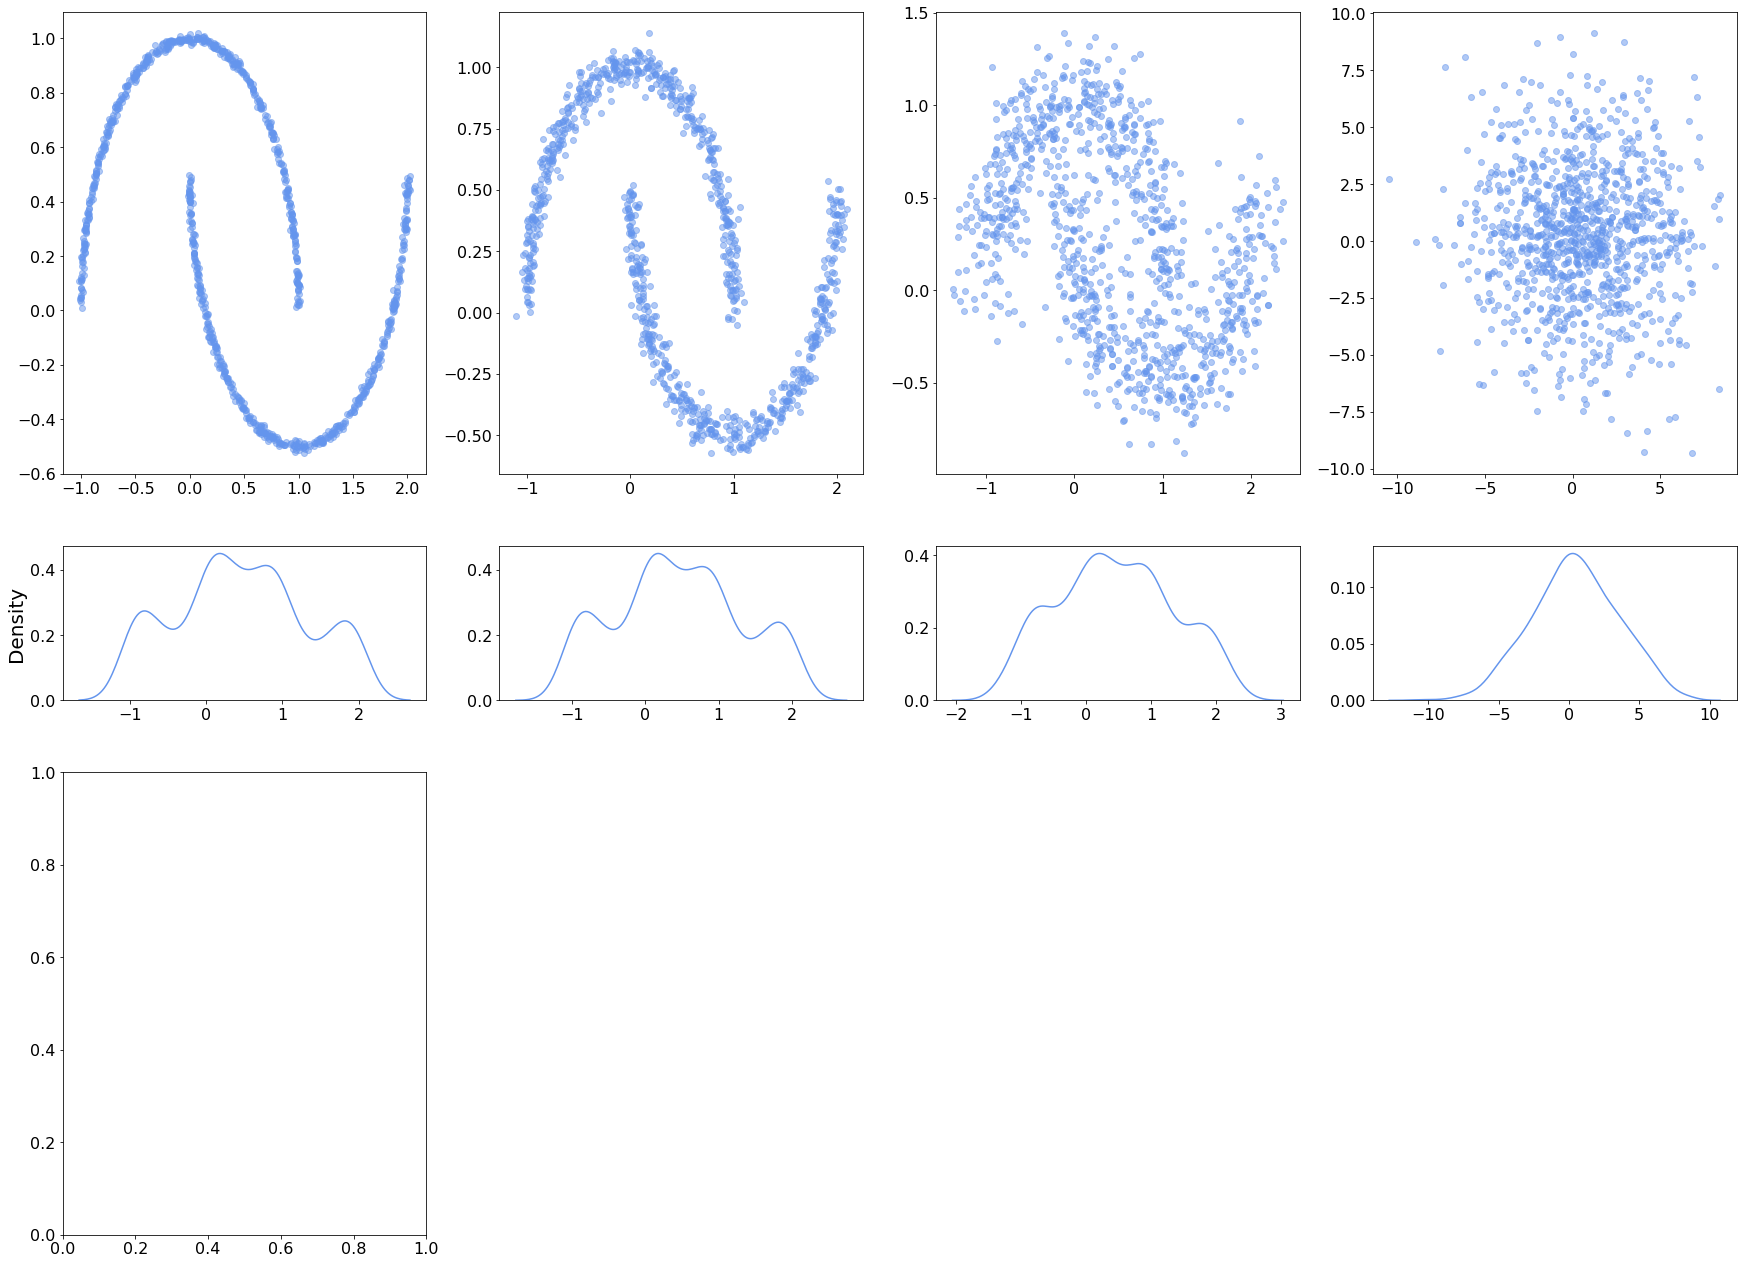

In [75]:
alpha = 0.5
col = 'cornflowerblue'

gs = gridspec.GridSpec(3, 4, height_ratios=[3, 1, 3]) 
fig = plt.figure(figsize=(30,22.5))

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = ['Computer Modern']

ax0 = plt.subplot(gs[0])
ax0.scatter(sample[:,0], sample[:,1], alpha=alpha, color=col)

ax1 = plt.subplot(gs[1])
ax1.scatter(qtr[:,0], qtr[:,1], alpha=alpha, color=col)

ax2 = plt.subplot(gs[2])
ax2.scatter(half[:,0], half[:,1], alpha=alpha, color=col)

ax3 = plt.subplot(gs[3])
ax3.scatter(full[:,0], full[:,1], alpha=alpha, color=col)

ax4 = plt.subplot(gs[4])
sns.kdeplot(sample[:,0], color=col)
plt.ylabel('Density', fontsize = 20)

ax5 = plt.subplot(gs[5])
sns.kdeplot(qtr[:,0], color=col)
plt.ylabel('')

ax6 = plt.subplot(gs[6])
sns.kdeplot(half[:,0], color=col)
plt.ylabel('')

ax7 = plt.subplot(gs[7])
sns.kdeplot(full[:,0], color=col)
plt.ylabel('')

ax8 = plt.subplot(gs[8])
plt.scatter(xs[-1][:,0], xs[-1][:,1], alpha=alpha, color=col)

ax9 = plt.subplot(gs[9])
plt.scatter(xs[-100][:,0], xs[-100][:,1], alpha=alpha, color=col)

ax10 = plt.subplot(gs[10])
plt.scatter(xs[-500][:,0], xs[-500][:,1], alpha=alpha, color=col)

ax11 = plt.subplot(gs[11])
plt.scatter(xs[0][:,0], xs[0][:,1], alpha=alpha, color=col)


#fig.savefig('plots/diffusion_basic_ex.png', bbox_inches='tight', pad_inches=0.1)

# SDE diffusion plots

## VE diffusion

In [23]:
def get_diffused(data, n, sde):
    data = data.copy()
    t = 1e-5
    dt = 1/n
    diffused = [data.copy()]
    for i in range(n):
        drift, diffusion = sde(data, t)
        
        data += drift * dt
        data += diffusion * np.random.randn(1)[0] * np.sqrt(dt)
        
        t += dt
        
        diffused.append(data.copy())
    
    return diffused

In [6]:
sigma_min=0.01
sigma_max=3
def sde_VE(x, t):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

In [33]:
def sde_VE(x, t, sigma_min, sigma_max):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

def get_diffused_2D(obs, n, sde, sigma_min, sigma_max):
    data = obs.clone().detach()
    t = 1e-5
    dt = 1/n
    diffused = [data.clone().detach()]
    for i in range(n):
        drift, diffusion = sde(data, t, sigma_min, sigma_max)
        data += drift * dt
        data += diffusion * torch.randn(2) * np.sqrt(dt)
        diffused.append(data.clone().detach())
        t += dt

    return torch.vstack(diffused)

In [61]:
diff = [get_diffused_2D(torch.tensor(sample[i]), 1000, sde_VE, 0.01, 3) for i in range(1000)]

In [62]:
og = torch.vstack([diff[i][0] for i in range(1000)])

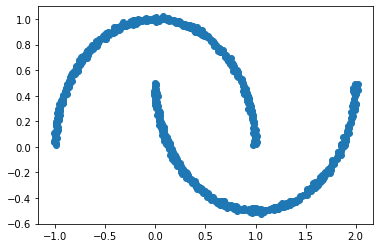

In [63]:
plt.scatter(og[:,0], og[:,1])

In [66]:
qtr = torch.vstack([diff[i][250] for i in range(1000)])

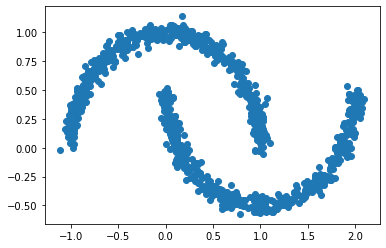

In [67]:
plt.scatter(qtr[:,0], qtr[:,1])

In [68]:
half = torch.vstack([diff[i][500] for i in range(1000)])

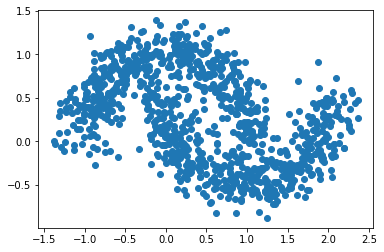

In [69]:
plt.scatter(half[:,0], half[:,1])

In [70]:
three_qtr = torch.vstack([diff[i][750] for i in range(1000)])

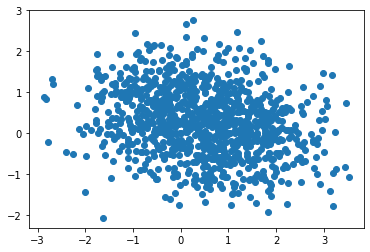

In [71]:
plt.scatter(three_qtr[:,0], three_qtr[:,1])

In [72]:
full = torch.vstack([diff[i][1000] for i in range(1000)])

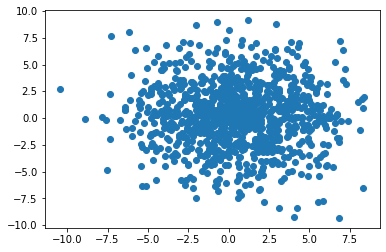

In [73]:
plt.scatter(full[:,0], full[:,1])

In [258]:
idx = np.random.choice(range(5000), 10000)
sample = moons[idx, 0]

In [259]:
walks = []
for i in sample:
    walk = get_diffused(i, 1000, sde_VE)
    walks.append(walk)

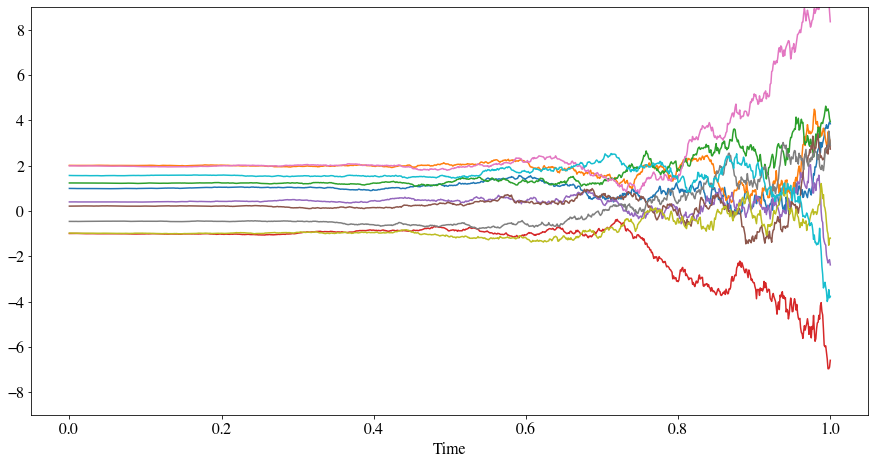

In [246]:
plt.rcParams.update({'font.size': 16})
font = 'Times'
hfont = {'fontname':font}
fig = plt.figure(figsize=(15,7.5))


    
for i in range(len(sample)):
    plt.plot(np.linspace(1e-5,1, 1001), walks[i])
    ax = plt.gca()
    ax.set_ylim([-9, 9])
    plt.xlabel('Time', **hfont)
    plt.yticks(fontname = font)
    plt.xticks(fontname = font)
    
#fig.savefig('plots/VE_SDE.png', bbox_inches='tight', pad_inches=0.1)

In [260]:
last = [w[-1] for w in walks]

In [262]:
np.mean(moons)

0.3751227022167259

Mean should be the same as the original datapoint (or 0??)

In [265]:
np.mean(last)

0.5214299077401613

Variance should be sigma_max^2, which is 3^2 = 9

In [266]:
np.var(last)

9.629794983654874

## VP diffusion

In [160]:
beta_min = 0.1
beta_max = 20
def sde_VP(x, t):
    beta_t = beta_min + t * (beta_max - beta_min)
    drift = -0.5 * beta_t * x
    diffusion = np.sqrt(beta_t)
    return drift, diffusion

In [239]:
walks = []

for i in sample:
    walk = get_diffused(i, 1000, sde_VP)
    walks.append(walk)

normal_dist = np.random.randn(100000)

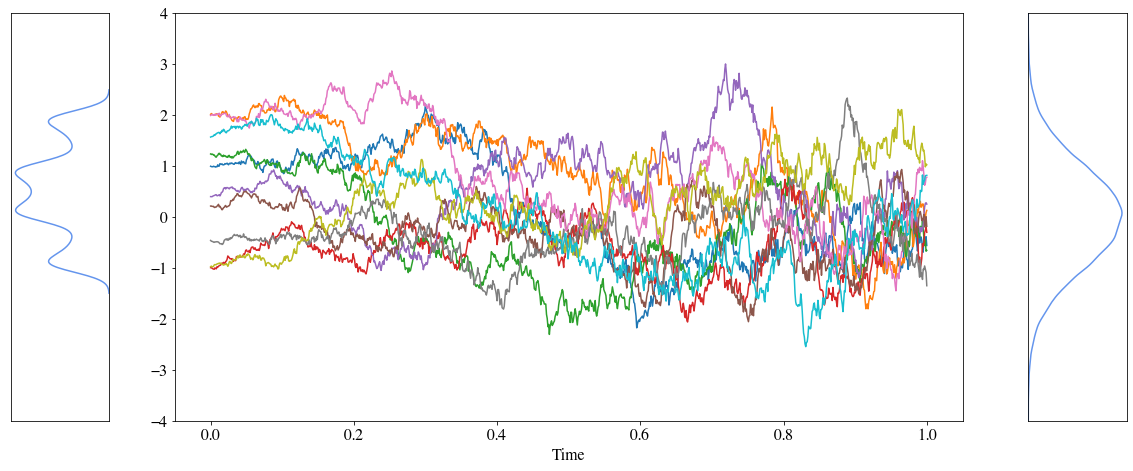

In [241]:
col = 'cornflowerblue'
plt.rcParams.update({'font.size': 16})
font = 'Times'
hfont = {'fontname':font}

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 8, 1]) 
fig = plt.figure(figsize=(20,7.5))

ax0 = plt.subplot(gs[0])
ax0 = sns.kdeplot(y=moons[:,0], color=col)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylim([-4, 4])
plt.xlabel('', **hfont)
ax0.invert_xaxis()


ax1 = plt.subplot(gs[1])
for i in range(len(sample)):
    ax1.plot(np.linspace(1e-5,1, 1001), walks[i])
    ax1.set_ylim([-4, 4])
    plt.xlabel('Time', **hfont)
    plt.yticks(fontname = font)
    plt.xticks(fontname = font)
    
ax2 = plt.subplot(gs[2])
ax2 = sns.kdeplot(y=normal_dist, color=col)
ax2.set_ylim([-4, 4])
ax2.set_xticks([])
ax2.set_yticks([])
plt.xlabel('', **hfont)

#fig.savefig('plots/VP_SDE.png', bbox_inches='tight', pad_inches=0.1)

In [232]:
last = [w[-1] for w in walks]

In [88]:
moons[[0], 0]

array([1.6790611])

Mean should be 0

In [89]:
np.mean(last)

0.0635854522577793

Variance should be 1

In [90]:
np.var(last)

0.142647671983721

# 2D Experiment Results

## Unconditional plots

In [3]:
ex_1 = torch.load('data/ex_1.pt')
ex_2 = torch.load('data/ex_2.pt')
ex_3 = torch.load('data/ex_3.pt')

In [27]:
idx = np.random.choice(50000, 10000)

In [28]:
samples_1 = ex_1[idx]
samples_2 = ex_2[idx]
samples_3 = ex_3[idx]

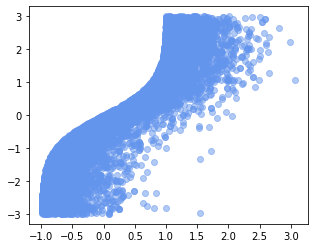

In [44]:
plt.figure(figsize=(5,4))
plt.scatter(samples_1[:,0], samples_1[:,1], color='cornflowerblue', alpha = 0.5)
plt.savefig('plots/ex_1.png', bbox_inches='tight', pad_inches=0.1)

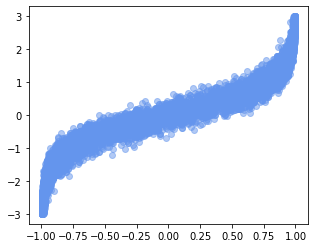

In [45]:
plt.figure(figsize=(5,4))
plt.scatter(samples_2[:,0], samples_2[:,1], color='cornflowerblue', alpha=0.5)
plt.savefig('plots/ex_2.png', bbox_inches='tight', pad_inches=0.1)

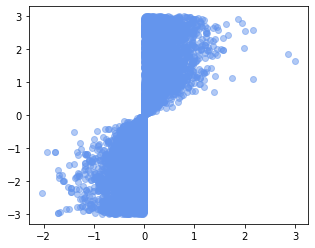

In [46]:
plt.figure(figsize=(5,4))
plt.scatter(samples_3[:,0], samples_3[:,1], color='cornflowerblue', alpha=0.5)
plt.savefig('plots/ex_3.png', bbox_inches='tight', pad_inches=0.1)

## Conditional plots

In [2]:
cde_samples_0 = torch.load('data/cde_0_1.pt')
cde_samples_pos = torch.load('data/cde_pos_1.pt')
cde_samples_neg = torch.load('data/cde_neg_1.pt')
cde_samples_0_2 = torch.load('data/cde_0_2.pt')
cde_samples_pos_2 = torch.load('data/cde_pos_2.pt')
cde_samples_neg_2 = torch.load('data/cde_neg_2.pt')
cde_samples_pos_3 = torch.load('data/cde_pos_3.pt')
cde_samples_neg_3 = torch.load('data/cde_neg_3.pt')

In [3]:
cdiffe_samples_0 = torch.load('data/cdiffe_0_1.pt')
cdiffe_samples_pos = torch.load('data/cdiffe_pos_1.pt')
cdiffe_samples_neg = torch.load('data/cdiffe_neg_1.pt')
cdiffe_samples_0_2 = torch.load('data/cdiffe_0_2.pt')
cdiffe_samples_pos_2 = torch.load('data/cdiffe_pos_2.pt')
cdiffe_samples_neg_2 = torch.load('data/cdiffe_neg_2.pt')
cdiffe_samples_pos_3 = torch.load('data/cdiffe_pos_3.pt')
cdiffe_samples_neg_3 = torch.load('data/cdiffe_neg_3.pt')

In [4]:
smcdiff_samples_0 = torch.load('data/smcdiff_0_1.pt')
smcdiff_samples_pos = torch.load('data/smcdiff_pos_1.pt')
smcdiff_samples_neg = torch.load('data/smcdiff_neg_1.pt')
smcdiff_samples_0_2 = torch.load('data/smcdiff_0_2.pt')
smcdiff_samples_pos_2 = torch.load('data/smcdiff_pos_2.pt')
smcdiff_samples_neg_2 = torch.load('data/smcdiff_neg_2.pt')
smcdiff_samples_pos_3 = torch.load('data/smcdiff_pos_3.pt')
smcdiff_samples_neg_3 = torch.load('data/smcdiff_neg_3.pt')

In [5]:
actual_samples_pos = np.random.gamma(1,0.3, size = 100000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 100000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 100000) + np.tanh(-1.2)

actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) - 1.2)

actual_samples_pos_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(1.2)
actual_samples_neg_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(-1.2)

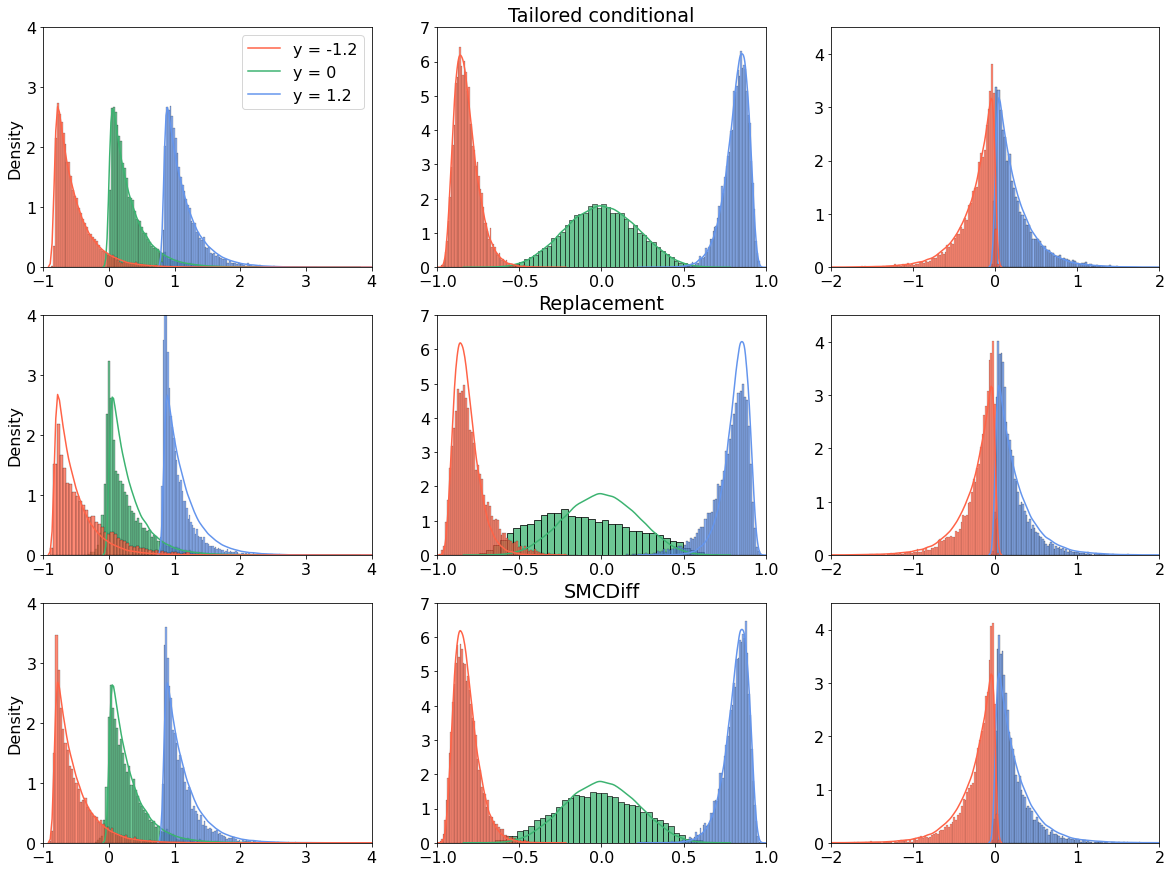

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
plt.rcParams.update({'font.size': 16})

def plot_row(s1,s2,s3,s4,s5,s6,s7,s8,row,title):
    sns.kdeplot(actual_samples_0, color = 'mediumseagreen', ax = axs[row,0])
    sns.histplot(s1[:,0], stat = 'density', color = 'mediumseagreen', ax = axs[row,0])
    sns.kdeplot(actual_samples_pos, color = 'cornflowerblue', ax = axs[row,0])
    sns.histplot(s2[:,0], stat = 'density', color = 'cornflowerblue', ax = axs[row,0])
    sns.kdeplot(actual_samples_neg, color = 'tomato', ax = axs[row,0])
    sns.histplot(s3[:,0], stat = 'density', color = 'tomato', ax = axs[row,0])
    
    
    test = sns.kdeplot(actual_samples_0_2, color = 'mediumseagreen', ax = axs[row,1])
    test.set(ylabel=' ')
    sns.histplot(s4[:,0], stat = 'density', color = 'mediumseagreen', ax = axs[row,1])
    sns.kdeplot(actual_samples_pos_2, color = 'cornflowerblue', ax = axs[row,1])
    sns.histplot(s5[:,0], stat = 'density', color = 'cornflowerblue', ax = axs[row,1])
    sns.kdeplot(actual_samples_neg_2, color = 'tomato', ax = axs[row,1])
    sns.histplot(s6[:,0], stat = 'density', color = 'tomato', ax = axs[row,1])

    test = sns.kdeplot(actual_samples_pos_3, color = 'cornflowerblue', ax = axs[row,2])
    test.set(ylabel=' ')
    sns.histplot(s7[:,0], stat = 'density', color = 'cornflowerblue', ax = axs[row,2])
    sns.kdeplot(actual_samples_neg_3, color = 'tomato', ax = axs[row,2])
    sns.histplot(s8[:,0], stat = 'density', color = 'tomato', ax = axs[row,2])


    axs[row,1].set_title(title)
    
    axs[row][0].set_xlim(-1, 4)
    axs[row][0].set_ylim(0, 4)

    axs[row][1].set_xlim(-1, 1)
    axs[row][1].set_ylim(0, 7)

    axs[row][2].set_xlim(-2, 2)
    axs[row][2].set_ylim(0, 4.5)


    
plot_row(cde_samples_0, cde_samples_pos, cde_samples_neg, 
         cde_samples_0_2, cde_samples_pos_2, cde_samples_neg_2,
         cde_samples_pos_3, cde_samples_neg_3, 0, 'Tailored conditional')

plot_row(cdiffe_samples_0, cdiffe_samples_pos, cdiffe_samples_neg, 
         cdiffe_samples_0_2, cdiffe_samples_pos_2, cdiffe_samples_neg_2,
         cdiffe_samples_pos_3, cdiffe_samples_neg_3, 1, 'Replacement')

plot_row(smcdiff_samples_0, smcdiff_samples_pos, smcdiff_samples_neg, 
         smcdiff_samples_0_2, smcdiff_samples_pos_2, smcdiff_samples_neg_2,
         smcdiff_samples_pos_3, smcdiff_samples_neg_3, 2, 'SMCDiff')

axs[0][0].legend(["y = -1.2", "y = 0", "y = 1.2"], loc ="upper right", prop={'size': 16})
leg = axs[0][0].get_legend()
leg.legendHandles[0].set_color('tomato')
leg.legendHandles[1].set_color('mediumseagreen')
leg.legendHandles[2].set_color('cornflowerblue')
#plt.savefig('plots/2D_results.png', bbox_inches='tight', pad_inches=0.1)

In [29]:
print(np.mean(actual_samples_0))
print(f'CDE: {torch.mean(cde_samples_0)}')
print(f'Replacement: {torch.mean(cdiffe_samples_0)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_0)}')

0.30058948997820195
CDE: 0.30665385723114014
Replacement: 0.24525146186351776
SMCDiff: 0.2812317907810211


In [30]:
print(np.mean(actual_samples_pos))
print(f'CDE: {torch.mean(cde_samples_pos)}')
print(f'Replacement: {torch.mean(cdiffe_samples_pos)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_pos)}')

1.1334595980803381
CDE: 1.1231945753097534
Replacement: 1.0317052602767944
SMCDiff: 1.0813982486724854


In [31]:
print(np.mean(actual_samples_neg))
print(f'CDE: {torch.mean(cde_samples_neg)}')
print(f'Replacement: {torch.mean(cdiffe_samples_neg)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_neg)}')

-0.5340662252207486
CDE: -0.5241797566413879
Replacement: -0.379474401473999
SMCDiff: -0.5254701375961304


In [32]:
print(np.mean(actual_samples_0_2))
print(f'CDE: {torch.mean(cde_samples_0_2)}')
print(f'Replacement: {torch.mean(cdiffe_samples_0_2)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_0_2)}')

0.00018844400989962473
CDE: -0.0031802195589989424
Replacement: -0.1059098020195961
SMCDiff: -0.020346157252788544


In [33]:
print(np.mean(actual_samples_pos_2))
print(f'CDE: {torch.mean(cde_samples_pos_2)}')
print(f'Replacement: {torch.mean(cdiffe_samples_pos_2)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_pos_2)}')

0.8206311736324481
CDE: 0.8198021650314331
Replacement: 0.7789686322212219
SMCDiff: 0.815613865852356


In [34]:
print(np.mean(actual_samples_neg_2))
print(f'CDE: {torch.mean(cde_samples_neg_2)}')
print(f'Replacement: {torch.mean(cdiffe_samples_neg_2)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_neg_2)}')

-0.8208029613891983
CDE: -0.8171448111534119
Replacement: -0.7913666367530823
SMCDiff: -0.8186662197113037


In [35]:
print(np.mean(actual_samples_pos_3))
print(f'CDE: {torch.mean(cde_samples_pos_3)}')
print(f'Replacement: {torch.mean(cdiffe_samples_pos_3)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_pos_3)}')

0.25041757209193427
CDE: 0.2496189922094345
Replacement: 0.21512021124362946
SMCDiff: 0.21776743233203888


In [36]:
print(np.mean(actual_samples_neg_3))
print(f'CDE: {torch.mean(cde_samples_neg_3)}')
print(f'Replacement: {torch.mean(cdiffe_samples_neg_3)}')
print(f'SMCDiff: {torch.mean(smcdiff_samples_neg_3)}')

-0.2480476354328925
CDE: -0.23583891987800598
Replacement: -0.2191780060529709
SMCDiff: -0.21943901479244232


# BOD Experiment Results

In [28]:
mcmc = torch.load('data/BOD_mcmc.pt')
cde = torch.load('data/BOD_cde_samples.pt')
cdiffe = torch.load('data/BOD_cdiffe_samples.pt')
smcdiff = torch.load('data/BOD_smcdiff_samples.pt')

In [57]:
mcmc_df = pd.DataFrame(mcmc.numpy())
mcmc_df['method'] = 'MCMC'
mcmc_df.columns = ['x1','x2','method']
cdiffe_df = pd.DataFrame(cdiffe[:,[0,1]].numpy())
cdiffe_df['method'] = 'Replacement'
cdiffe_df.columns = ['x1','x2','method']
cde_df = pd.DataFrame(cde[:,[0,1]].numpy())
cde_df['method'] = 'Tailored conditional'
cde_df.columns = ['x1','x2','method']
smcdiff_df = pd.DataFrame(smcdiff[:,[0,1]].numpy())
smcdiff_df['method'] = 'SMCDiff'
smcdiff_df.columns = ['x1','x2','method']

combined = pd.concat([mcmc_df, cdiffe_df, cde_df, smcdiff_df])

combined.columns = ['x1','x2','method']

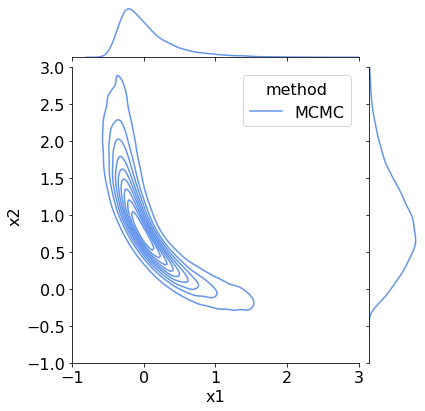

In [115]:
ax = sns.jointplot(data = combined.loc[combined['method']=='MCMC'], x ='x1', y='x2', 
            kind='kde', hue = 'method', palette=['cornflowerblue'])
ax.ax_marg_x.set_xlim(-1, 3)
ax.ax_marg_y.set_ylim(-1, 3)
plt.savefig('plots/BOD_mcmc.png', bbox_inches='tight', pad_inches=0.1)

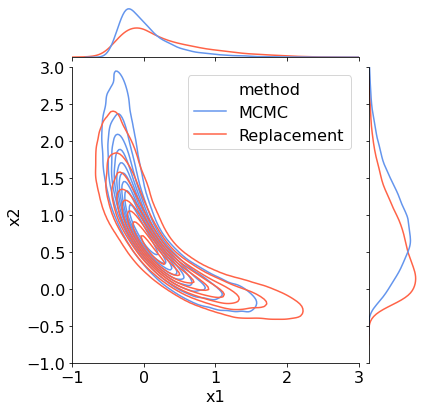

In [110]:
ax = sns.jointplot(data = combined.loc[combined['method'].isin(('MCMC', 'Replacement'))], x ='x1', y='x2', 
            kind='kde', hue = 'method', palette=['cornflowerblue', 'tomato'])
ax.ax_marg_x.set_xlim(-1, 3)
ax.ax_marg_y.set_ylim(-1, 3)
plt.savefig('plots/BOD_replacement.png', bbox_inches='tight', pad_inches=0.1)

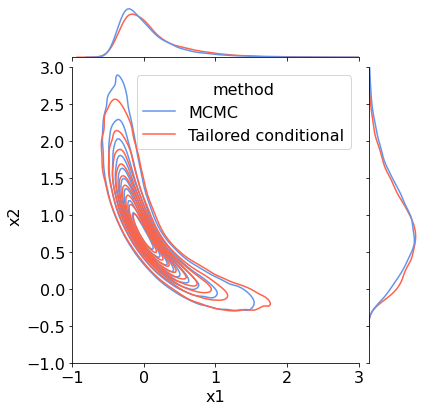

In [111]:
ax = sns.jointplot(data = combined.loc[combined['method'].isin(('MCMC', 'Tailored conditional'))], x ='x1', y='x2', 
            kind='kde', hue = 'method', palette=['cornflowerblue', 'tomato'])
ax.ax_marg_x.set_xlim(-1, 3)
ax.ax_marg_y.set_ylim(-1, 3)
plt.savefig('plots/BOD_cde.png', bbox_inches='tight', pad_inches=0.1)

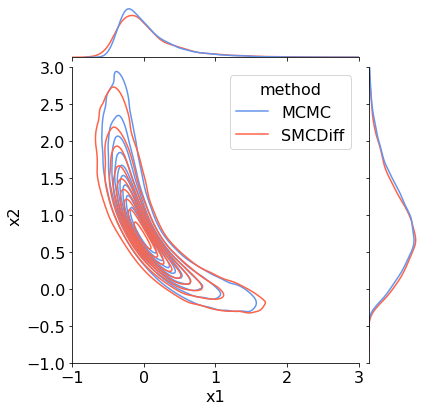

In [112]:
ax = sns.jointplot(data=combined.loc[combined['method'].isin(('MCMC', 'SMCDiff'))], x ='x1', y='x2', 
            kind='kde', hue = 'method', palette=['cornflowerblue', 'tomato'])
ax.ax_marg_x.set_xlim(-1, 3)
ax.ax_marg_y.set_ylim(-1, 3)
plt.savefig('plots/BOD_smcdiff.png', bbox_inches='tight', pad_inches=0.1)

In [52]:
norm = np.random.randn(10000,2) * 13
norm_df = pd.DataFrame(norm)
norm_df.columns = ['x1', 'x2']

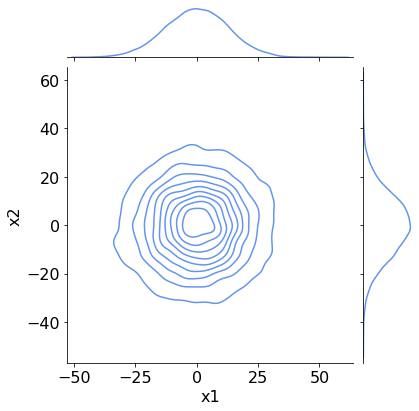

In [53]:
ax = sns.jointplot(data = norm_df, x ='x1', y='x2', kind='kde',color='cornflowerblue')

#plt.savefig('plots/BOD_mcmc.png', bbox_inches='tight', pad_inches=0.1)

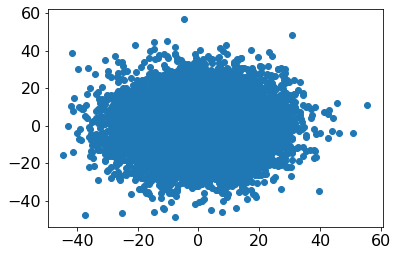

In [54]:
plt.scatter(norm[:,0], norm[:,1])

# MNIST Experiment Results

In [35]:
test_data = MNIST('./data', train=True, transform=transforms.ToTensor())

In [14]:
zero = test_data[3][0][0]
one = test_data[2][0][0]
two = test_data[1][0][0]
three = test_data[30][0][0]
four = test_data[27][0][0]
five = test_data[23][0][0]
six = test_data[21][0][0]
seven = test_data[0][0][0]
eight = test_data[61][0][0]
nine = test_data[12][0][0]

In [54]:
random_samples = []
num=0
for image, label in test_data:
    random_samples.append(image)
    
    num += 1
    if num >= 16:
        break

In [55]:
random_samples = torch.stack(random_samples)

In [56]:
random_samples.shape

torch.Size([16, 1, 28, 28])

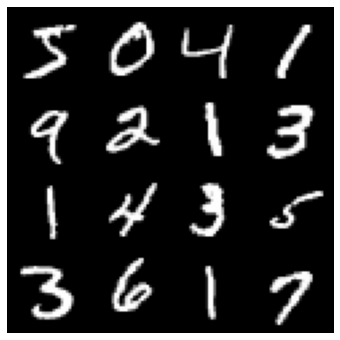

In [57]:
sample_grid = make_grid(random_samples, nrow=int(np.sqrt(16)))

plt.figure(figsize=(16,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
#plt.show()
plt.savefig('plots/MNIST_actual_samples.png', bbox_inches='tight', pad_inches=0.1)

In [42]:
idx = np.random.choice(256, 16)

In [43]:
smcdiff_three = torch.load('data/MNIST_smcdiff_64/smcdiff_64_threes.pt', map_location=torch.device('cpu'))[idx]

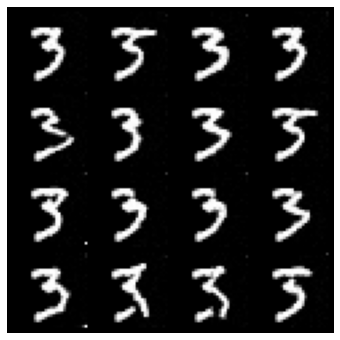

In [44]:
sample_grid = make_grid(smcdiff_three, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
plt.show()

In [45]:
cdiffe_three = torch.load('data/MNIST_cdiffe/cdiffe_threes.pt', map_location=torch.device('cpu'))[idx]

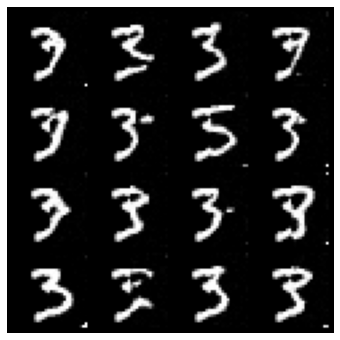

In [46]:
sample_grid = make_grid(cdiffe_three, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
plt.show()

In [51]:
cde_three =  torch.load('data/MNIST_cde/cde_threes.pt', map_location=torch.device('cpu'))[idx]

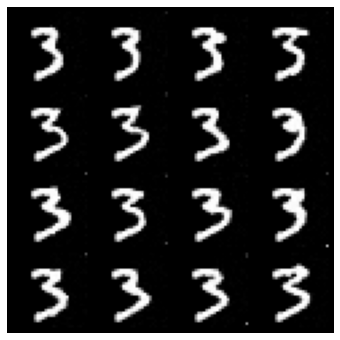

In [52]:
sample_grid = make_grid(cde_three, nrow=int(np.sqrt(16)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
plt.show()

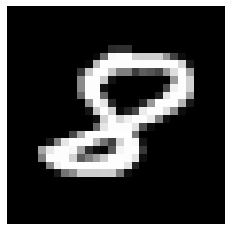

In [53]:
plt.imshow(eight, cmap='gray')
plt.axis('off')
plt.show()

In [47]:
three_half = three.clone().detach()

In [48]:
three_half[:,14:] = 0.5

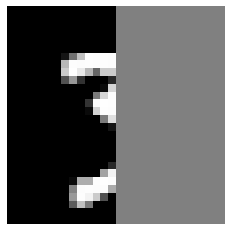

In [50]:
plt.imshow(three_half, cmap='gray')
plt.axis('off')
plt.show()

In [54]:
eight_half = eight.clone().detach()

In [55]:
eight_half[:,14:] = 0.5

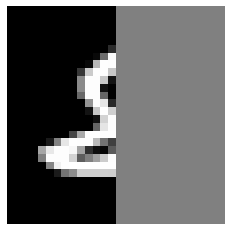

In [56]:
plt.imshow(eight_half, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
def plot_MNIST_single(number1, idx, save=False):
    true1 = torch.load(f'data/MNIST_{number1}.pt')
    
    if number1 == 'six':
        cde1 = torch.load(f'data/MNIST_cde/cde_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        cdiffe1 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        smcdiff1 = torch.load(f'data/MNIST_smcdiff_256/smcdiff_256_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        
    else:
        cde1 = torch.load(f'data/MNIST_cde/cde_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        cdiffe1 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        smcdiff1 = torch.load(f'data/MNIST_smcdiff_256/smcdiff_256_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        
    
    cde_grid1 = make_grid(cde1, nrow=int(np.sqrt(16)))
    cdiffe_grid1 = make_grid(cdiffe1, nrow=int(np.sqrt(16)))
    smcdiff_grid1 = make_grid(smcdiff1, nrow=int(np.sqrt(16)))
    
   
    masked1 = true1.clone().detach()
    masked1[:,14:] = 0.5
    
  
    
    f, ax = plt.subplots(1,5, figsize=(16, 10),constrained_layout = False)
    f.subplots_adjust(wspace=0.05)
    f.subplots_adjust(hspace=0.05)
    
    ax[0].imshow(true1, cmap = 'gray')
    ax[1].imshow(masked1, cmap = 'gray')
    ax[2].imshow(cde_grid1.permute(1, 2, 0))
    ax[3].imshow(cdiffe_grid1.permute(1, 2, 0))
    ax[4].imshow(smcdiff_grid1.permute(1, 2, 0))
    
   
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    
    
    
    ax[0].set_title('True', fontsize=16)
    ax[1].set_title('Masked condition', fontsize=16)
    ax[2].set_title('Tailored conditional', fontsize=16)
    ax[3].set_title('Replacement method', fontsize=16)
    ax[4].set_title('SMCDiff', fontsize=16)

    plt.show()
    
    if save:
        f.savefig(f'plots/MNIST_{number1}.png', bbox_inches='tight', pad_inches=0.1)

In [9]:
def plot_MNIST(number1, number2, number3, idx, save=False):
    true1 = torch.load(f'data/MNIST_{number1}.pt')
    true2 = torch.load(f'data/MNIST_{number2}.pt')
    true3 = torch.load(f'data/MNIST_{number3}.pt')
    if number1 == 'six':
        cde1 = torch.load(f'data/MNIST_cde/cde_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        cdiffe1 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        smcdiff1 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number1}es.pt', map_location=torch.device('cpu'))[idx]
        
    else:
        cde1 = torch.load(f'data/MNIST_cde/cde_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        cdiffe1 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        smcdiff1 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number1}s.pt', map_location=torch.device('cpu'))[idx]
        
    if number2 == 'six':
        cde2 = torch.load(f'data/MNIST_cde/cde_{number2}es.pt', map_location=torch.device('cpu'))[idx]
        cdiffe2 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number2}es.pt', map_location=torch.device('cpu'))[idx]
        smcdiff2 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number2}es.pt', map_location=torch.device('cpu'))[idx]
        
    else:
        cde2 = torch.load(f'data/MNIST_cde/cde_{number2}s.pt', map_location=torch.device('cpu'))[idx]
        cdiffe2 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number2}s.pt', map_location=torch.device('cpu'))[idx]
        smcdiff2 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number2}s.pt', map_location=torch.device('cpu'))[idx]
        
    if number3 == 'six':
        cde3 = torch.load(f'data/MNIST_cde/cde_{number3}es.pt', map_location=torch.device('cpu'))[idx]
        cdiffe3 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number3}es.pt', map_location=torch.device('cpu'))[idx]
        smcdiff3 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number3}es.pt', map_location=torch.device('cpu'))[idx]
        
    else:
        cde3 = torch.load(f'data/MNIST_cde/cde_{number3}s.pt', map_location=torch.device('cpu'))[idx]
        cdiffe3 = torch.load(f'data/MNIST_cdiffe/cdiffe_{number3}s.pt', map_location=torch.device('cpu'))[idx]
        smcdiff3 = torch.load(f'data/MNIST_smcdiff_512/smcdiff_512_{number3}s.pt', map_location=torch.device('cpu'))[idx]
        
    cde_grid1 = make_grid(cde1, nrow=int(np.sqrt(16)))
    cdiffe_grid1 = make_grid(cdiffe1, nrow=int(np.sqrt(16)))
    smcdiff_grid1 = make_grid(smcdiff1, nrow=int(np.sqrt(16)))
    
    cde_grid2 = make_grid(cde2, nrow=int(np.sqrt(16)))
    cdiffe_grid2 = make_grid(cdiffe2, nrow=int(np.sqrt(16)))
    smcdiff_grid2 = make_grid(smcdiff2, nrow=int(np.sqrt(16)))
    
    cde_grid3 = make_grid(cde3, nrow=int(np.sqrt(16)))
    cdiffe_grid3 = make_grid(cdiffe3, nrow=int(np.sqrt(16)))
    smcdiff_grid3 = make_grid(smcdiff3, nrow=int(np.sqrt(16)))

    masked1 = true1.clone().detach()
    masked1[:,14:] = 0.5
    
    masked2 = true2.clone().detach()
    masked2[:,14:] = 0.5
    
    masked3 = true3.clone().detach()
    masked3[:,14:] = 0.5
    
    f, ax = plt.subplots(3,5, figsize=(16, 10),constrained_layout = False)
    f.subplots_adjust(wspace=0.05)
    f.subplots_adjust(hspace=0.05)
    
    ax[0,0].imshow(true1, cmap = 'gray')
    ax[0,1].imshow(masked1, cmap = 'gray')
    ax[0,2].imshow(cde_grid1.permute(1, 2, 0))
    ax[0,3].imshow(cdiffe_grid1.permute(1, 2, 0))
    ax[0,4].imshow(smcdiff_grid1.permute(1, 2, 0))
    
    ax[1,0].imshow(true2, cmap = 'gray')
    ax[1,1].imshow(masked2, cmap = 'gray')
    ax[1,2].imshow(cde_grid2.permute(1, 2, 0))
    ax[1,3].imshow(cdiffe_grid2.permute(1, 2, 0))
    ax[1,4].imshow(smcdiff_grid2.permute(1, 2, 0))
    
    ax[2,0].imshow(true3, cmap = 'gray')
    ax[2,1].imshow(masked3, cmap = 'gray')
    ax[2,2].imshow(cde_grid3.permute(1, 2, 0))
    ax[2,3].imshow(cdiffe_grid3.permute(1, 2, 0))
    ax[2,4].imshow(smcdiff_grid3.permute(1, 2, 0))
    
    ax[0,0].axis('off')
    ax[0,1].axis('off')
    ax[0,2].axis('off')
    ax[0,3].axis('off')
    ax[0,4].axis('off')
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    ax[1,2].axis('off')
    ax[1,3].axis('off')
    ax[1,4].axis('off')
    ax[2,0].axis('off')
    ax[2,1].axis('off')
    ax[2,2].axis('off')
    ax[2,3].axis('off')
    ax[2,4].axis('off')
    
    
    ax[0,0].set_title('True', fontsize=16)
    ax[0,1].set_title('Masked condition', fontsize=16)
    ax[0,2].set_title('Tailored conditional', fontsize=16)
    ax[0,3].set_title('Replacement method', fontsize=16)
    ax[0,4].set_title('SMCDiff', fontsize=16)

    plt.show()
    
    if save:
        f.savefig(f'plots/MNIST_{number1}{number2}{number3}.png', bbox_inches='tight', pad_inches=0.1)

In [41]:
idx = np.random.choice(256, 16)

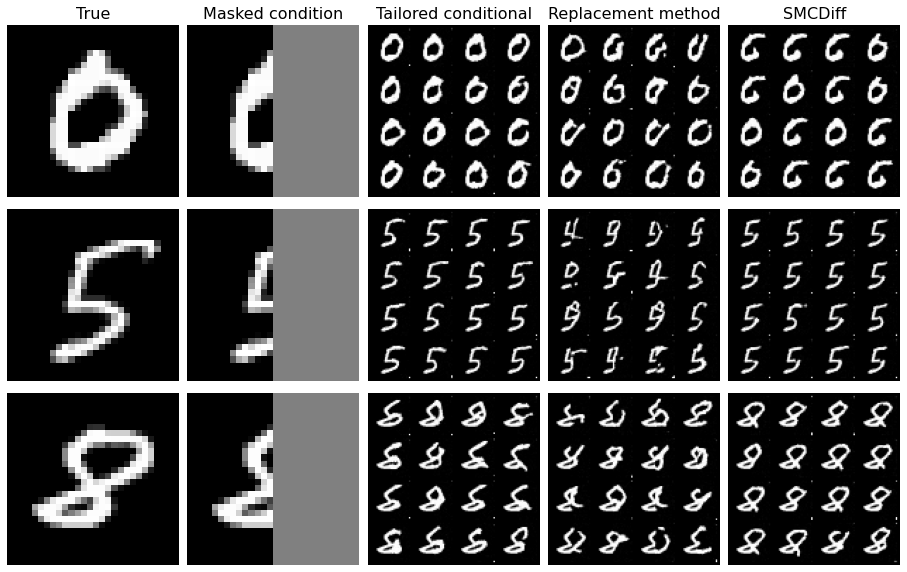

In [43]:
plot_MNIST('zero', 'five', 'eight', idx, save=True)

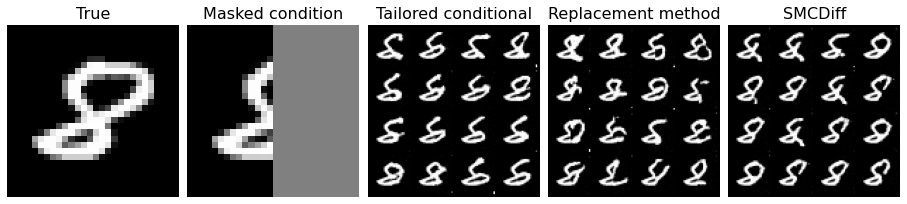

In [23]:
plot_MNIST_single('eight', idx)

In [2]:
smc_psnr = [13.1073, 13.5092, 13.9893, 14.5198, 14.6328, 15.3065, 15.2371, 15.7993, 15.7351, 15.6925]

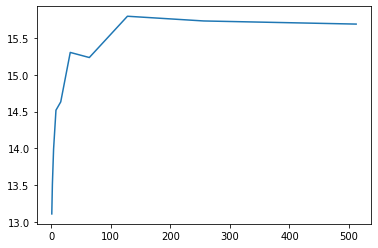

In [3]:
plt.plot([1,2,4,8,16,32,64,128,256,512], smc_psnr)

In [4]:
smc_ssim = [0.6124, 0.6419, 0.6740, 0.7023 , 0.7106 , 0.7451, 0.7460, 0.7640, 0.7651, 0.7626]

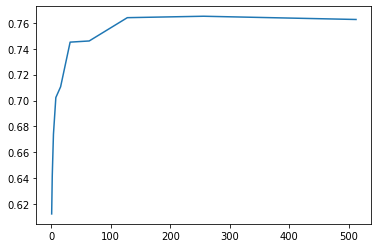

In [5]:
plt.plot([1,2,4,8,16,32,64,128,256,512], smc_ssim)

In [6]:
smc_lpips = [0.0804, 0.0704, 0.0618, 0.0579, 0.0573, 0.0504, 0.0497, 0.0460, 0.0450, 0.0463]

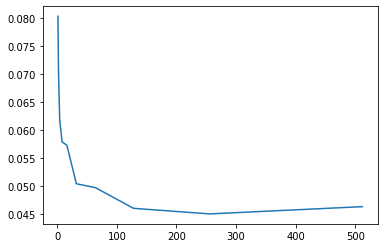

In [7]:
plt.plot([1,2,4,8,16,32,64,128,256,512], smc_lpips)

In [112]:
test = torch.load('data/MNIST_smcdiff_512/smcdiff_512_fives.pt', map_location='cpu')[0:100]

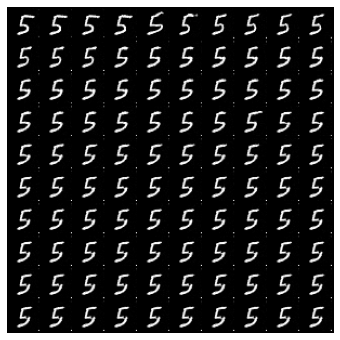

In [113]:
sample_grid = make_grid(test, nrow=int(np.sqrt(100)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
plt.show()

In [118]:
def plot_experiment(number, order):

    true = torch.load(f'data/MNIST_{number}.pt')
    cdes = []
    cdiffes = []
    smcdiffs = []

    if number == 'six':
        cdes = [torch.load(f'data/MNIST_cde/cde_exp_{number}es.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
        cdiffes = [torch.load(f'data/MNIST_cdiffe/cdiffe_exp_{number}es.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
        smcdiffs = [torch.load(f'data/MNIST_smcdiff_512/smcdiff_exp_{number}es.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
       

    else:
        cdes = [torch.load(f'data/MNIST_cde/cde_exp_{number}s.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
        cdiffes = [torch.load(f'data/MNIST_cdiffe/cdiffe_exp_{number}s.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
        smcdiffs = [torch.load(f'data/MNIST_smcdiff_512/smcdiff_exp_{number}s.pt', map_location=torch.device('cpu'))[i] for i in range(10)]
       

    samples = [cdes, cdiffes, smcdiffs]
    
    for i in range(10):
        print(i+1)
        ordering = order[i]
        
        f, ax = plt.subplots(1,4, figsize=(12, 12),constrained_layout = False)
        f.subplots_adjust(wspace=0.05)
        f.subplots_adjust(hspace=0.05)
        
        ax[0].imshow(true, cmap = 'gray')

        ax[1].imshow(samples[ordering[0]][i][0], cmap = 'gray')
        ax[2].imshow(samples[ordering[1]][i][0], cmap = 'gray')
        ax[3].imshow(samples[ordering[2]][i][0], cmap = 'gray')
        
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')
        
        ax[0].set_title('True', fontsize=16)
        ax[1].set_title('1', fontsize=16)
        ax[2].set_title('2', fontsize=16)
        ax[3].set_title('3', fontsize=16)
        plt.show()
    

# Experiment 1

In [113]:
rng = np.random.default_rng(0)
order = rng.permuted(np.tile([0,1,2], 10).reshape(10,3), axis=1)

1


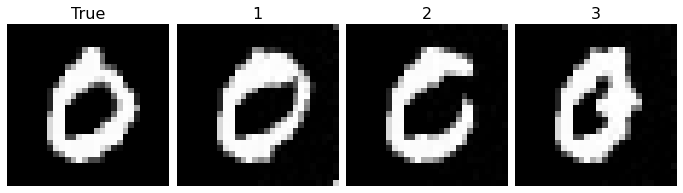

2


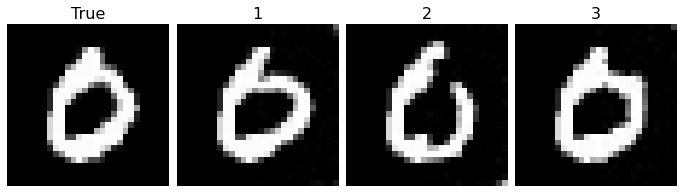

3


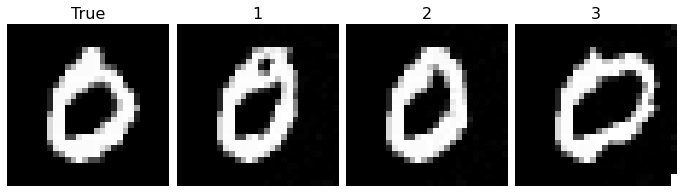

4


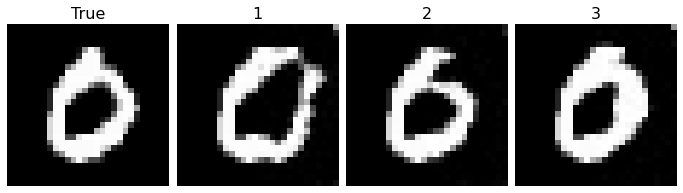

5


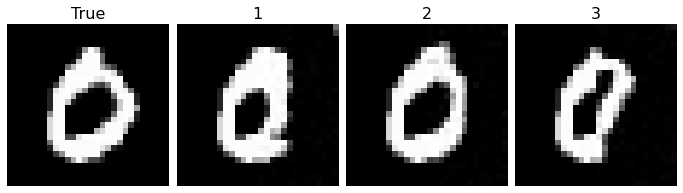

6


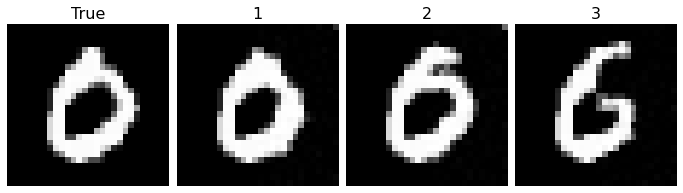

7


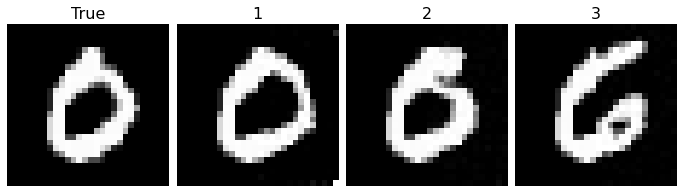

8


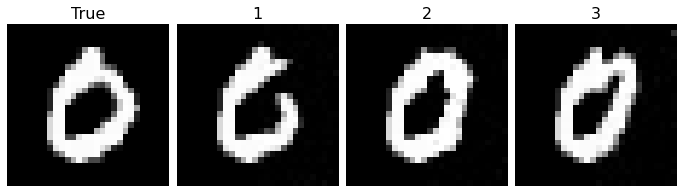

9


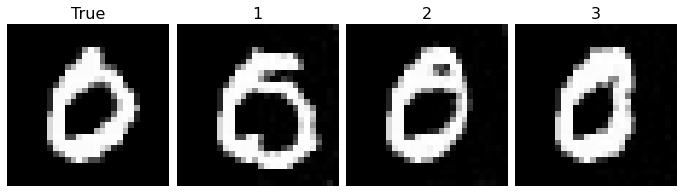

10


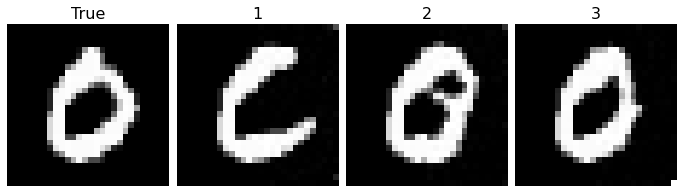

In [119]:
plot_experiment('zero',order)

1


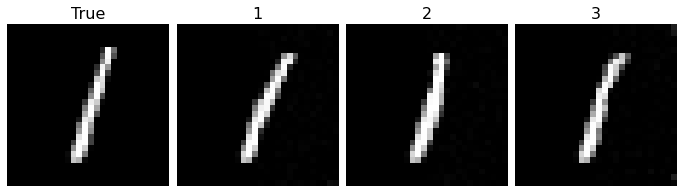

2


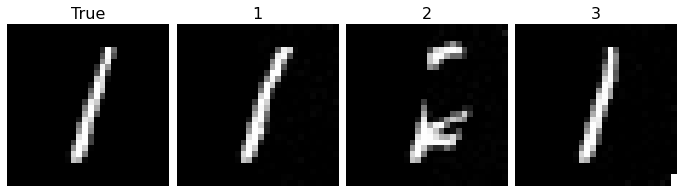

3


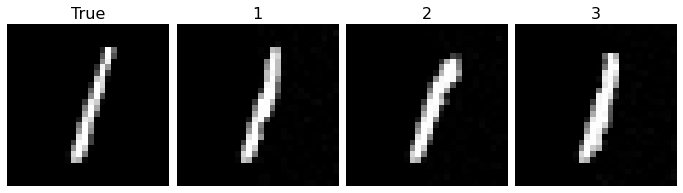

4


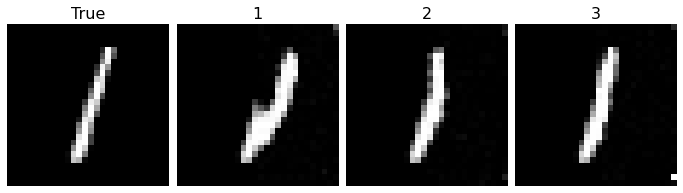

5


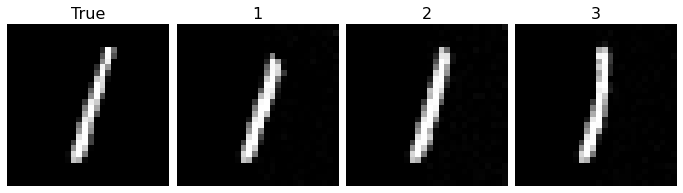

6


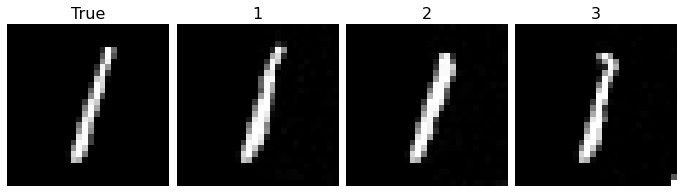

7


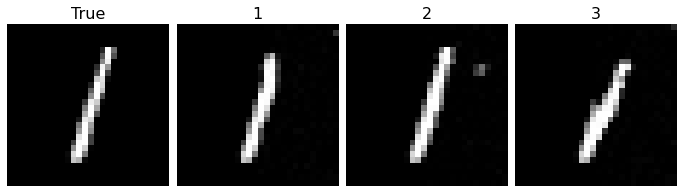

8


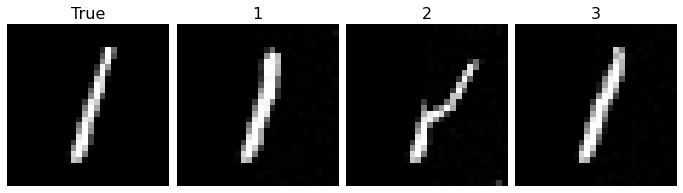

9


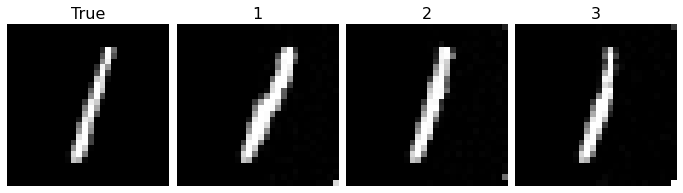

10


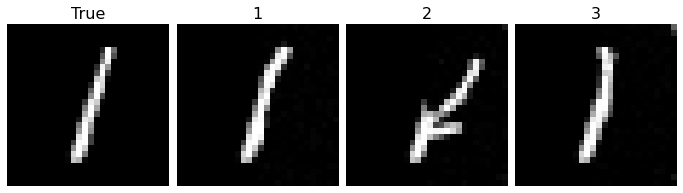

In [121]:
plot_experiment('one',order)

1


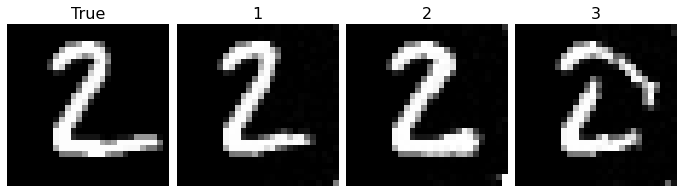

2


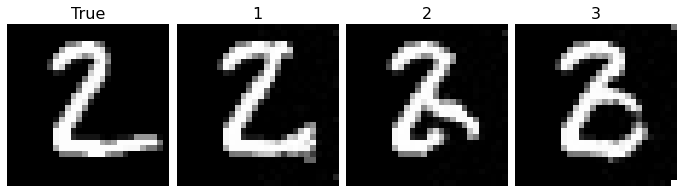

3


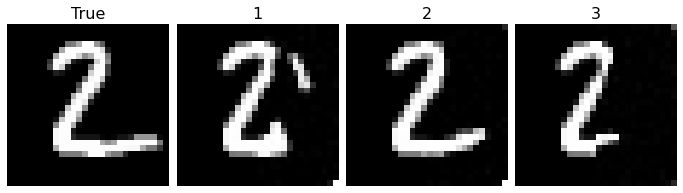

4


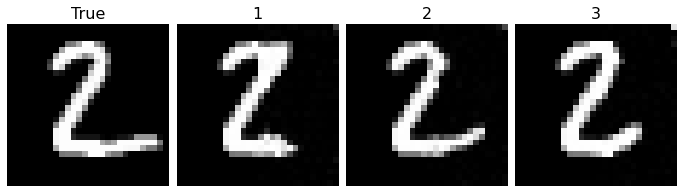

5


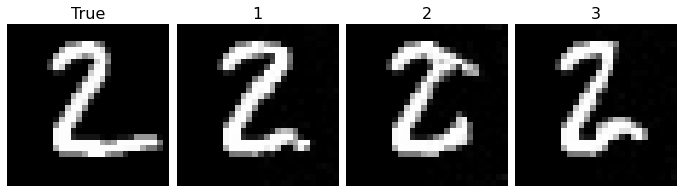

6


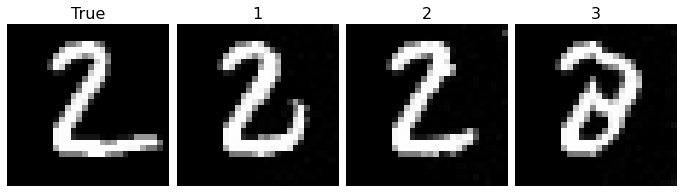

7


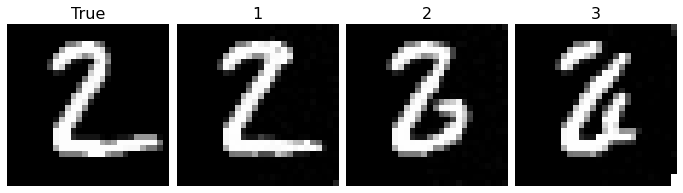

8


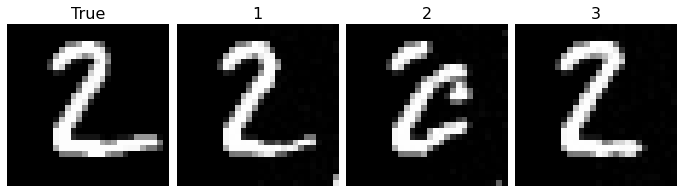

9


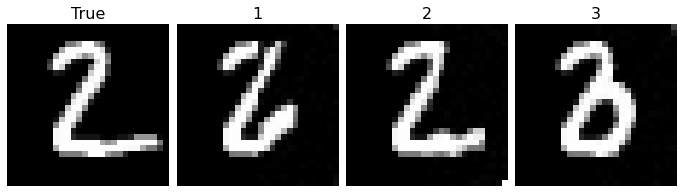

10


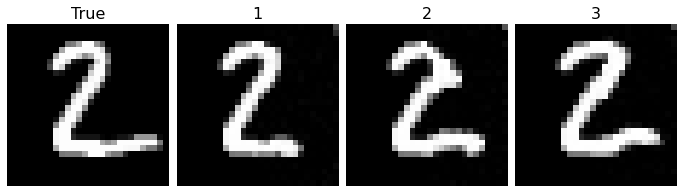

In [120]:
plot_experiment('two',order)

1


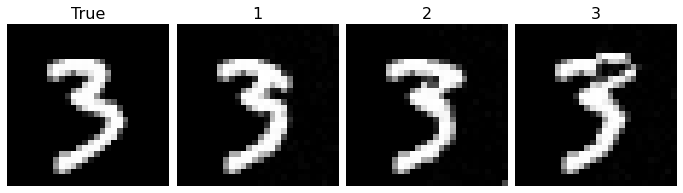

2


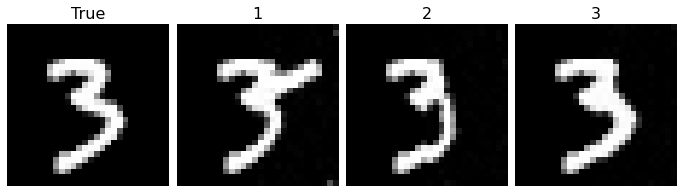

3


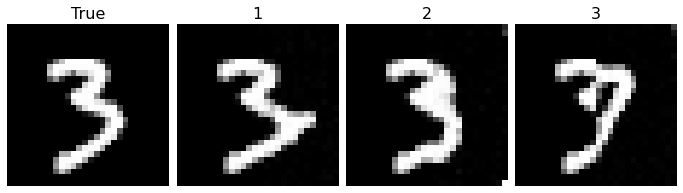

4


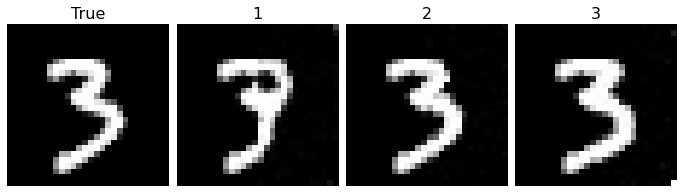

5


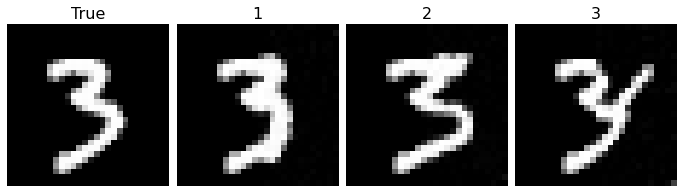

6


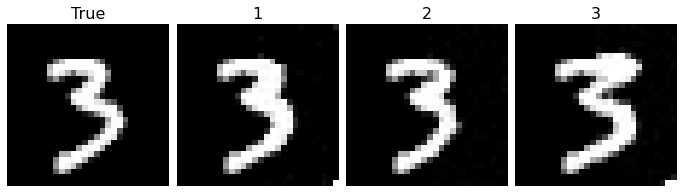

7


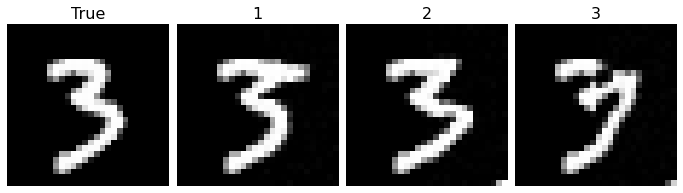

8


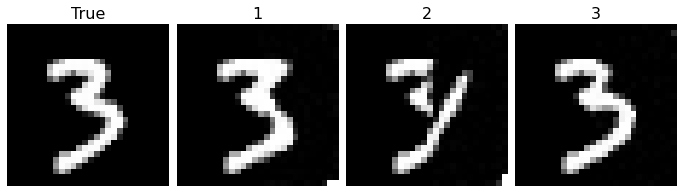

9


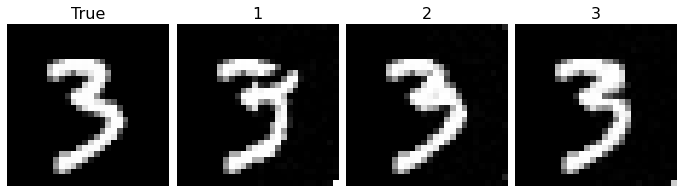

10


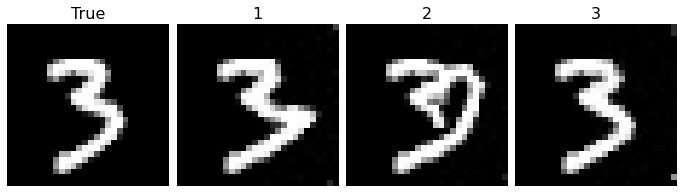

In [122]:
plot_experiment('three',order)

1


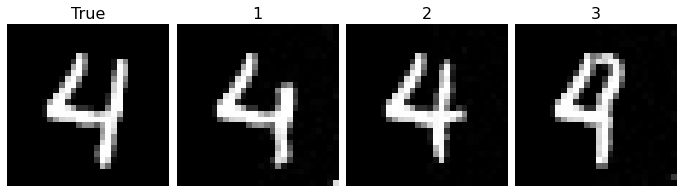

2


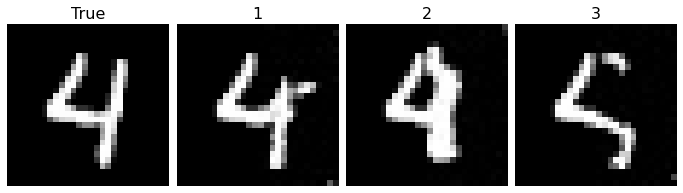

3


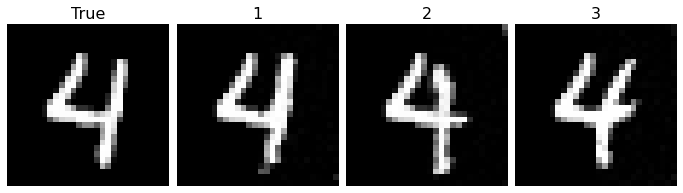

4


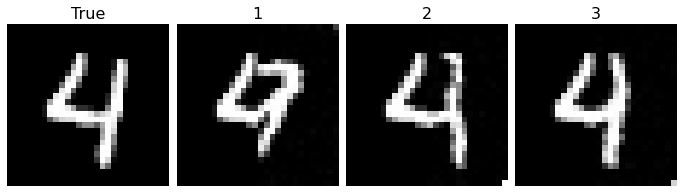

5


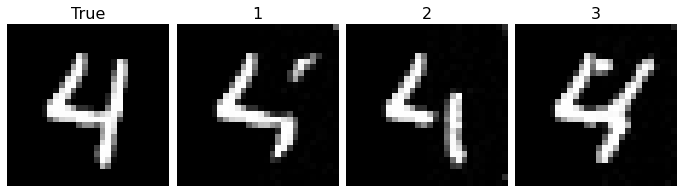

6


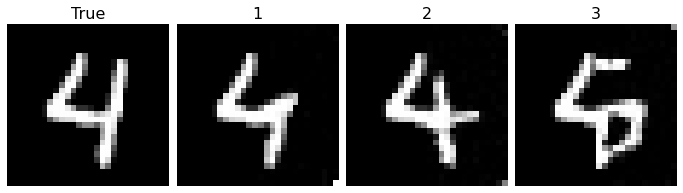

7


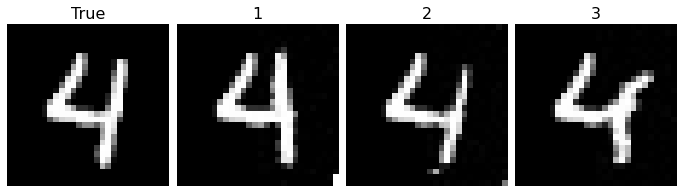

8


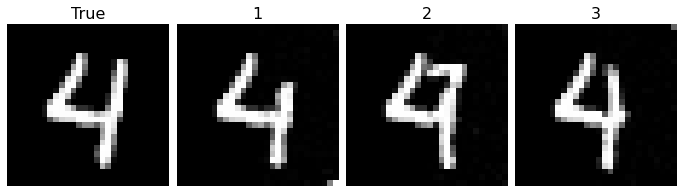

9


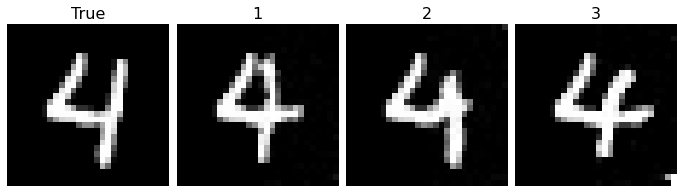

10


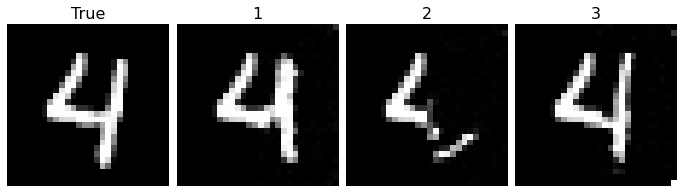

In [123]:
plot_experiment('four',order)

1


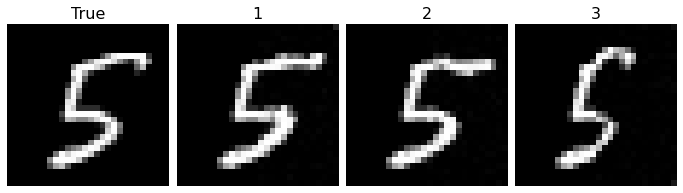

2


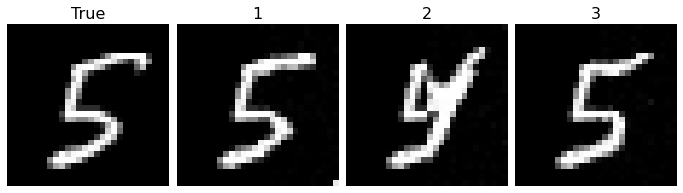

3


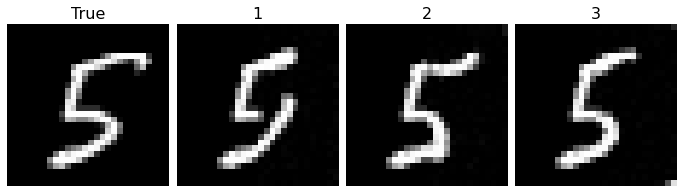

4


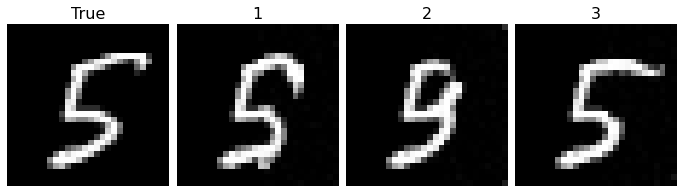

5


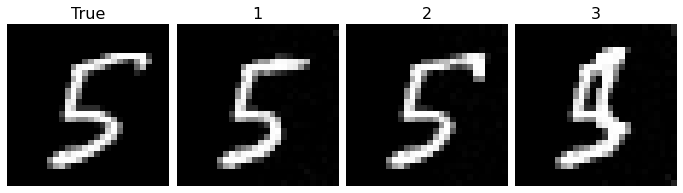

6


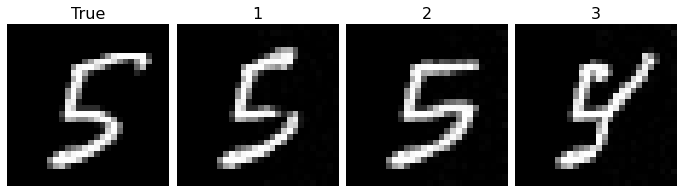

7


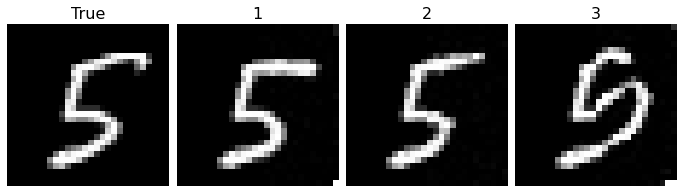

8


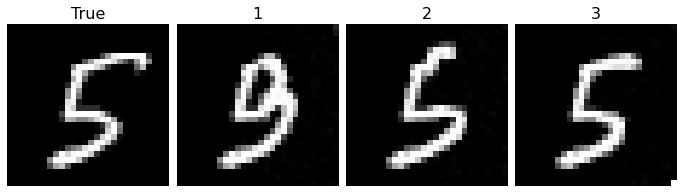

9


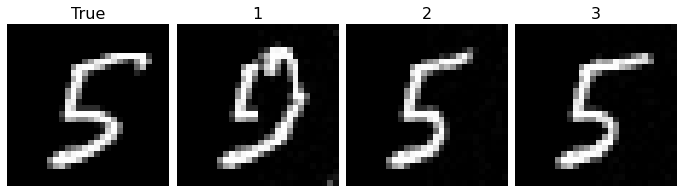

10


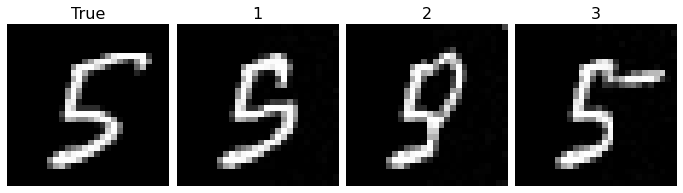

In [124]:
plot_experiment('five',order)

1


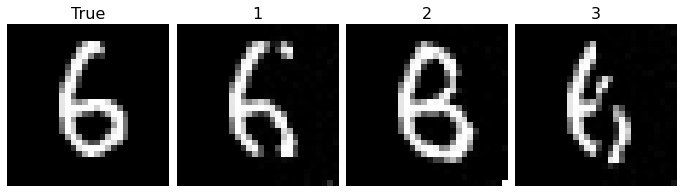

2


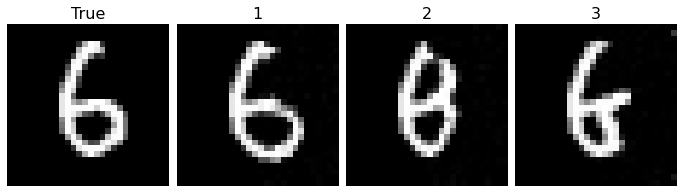

3


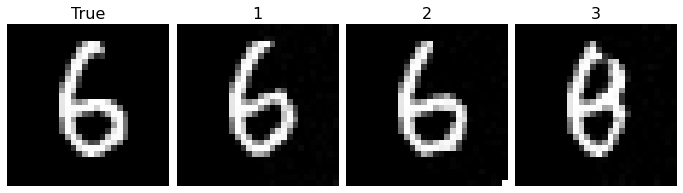

4


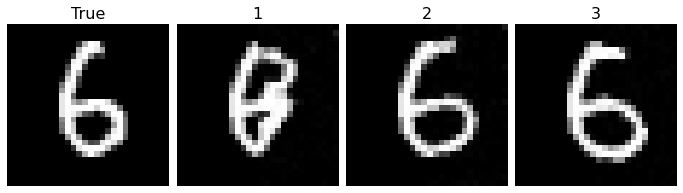

5


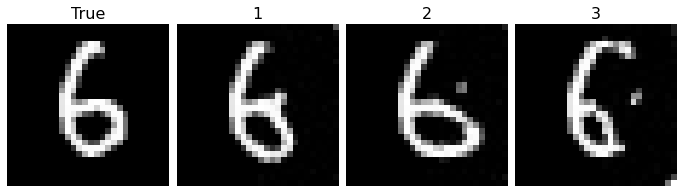

6


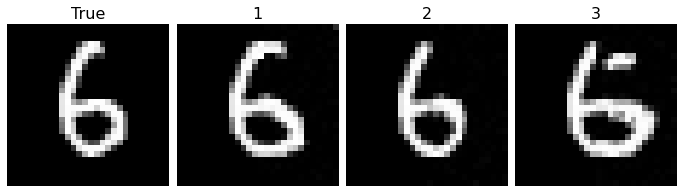

7


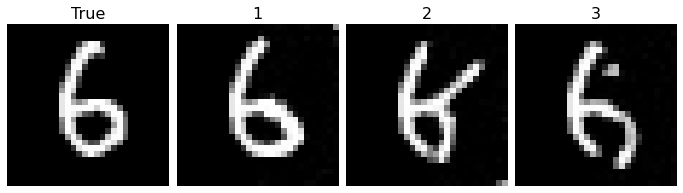

8


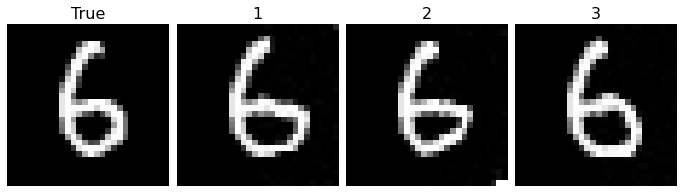

9


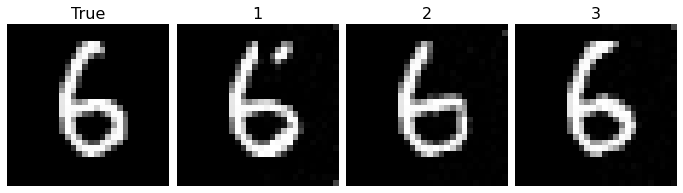

10


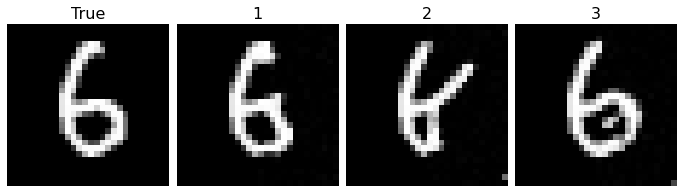

In [125]:
plot_experiment('six',order)

1


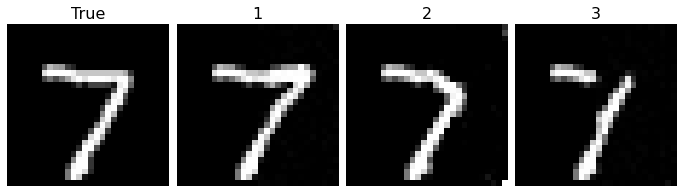

2


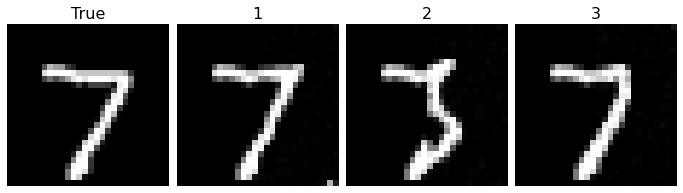

3


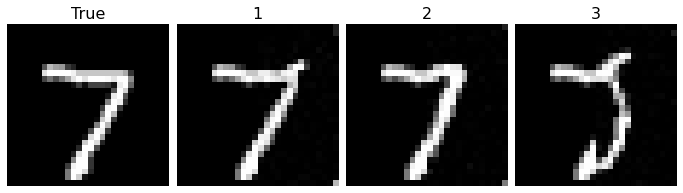

4


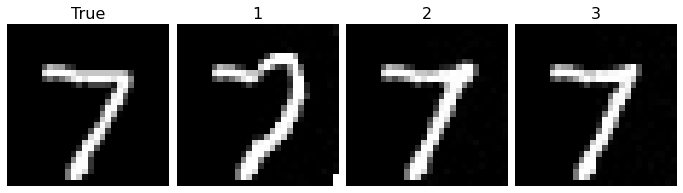

5


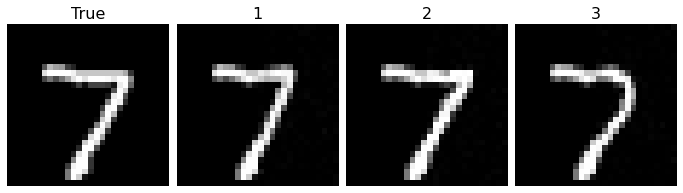

6


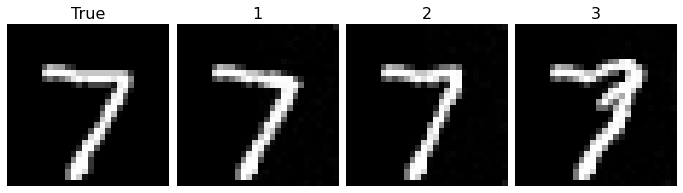

7


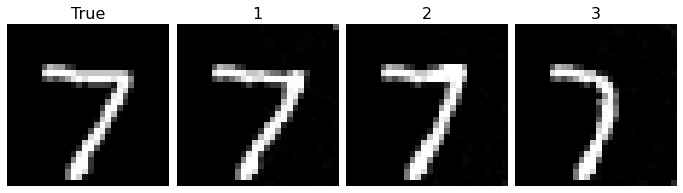

8


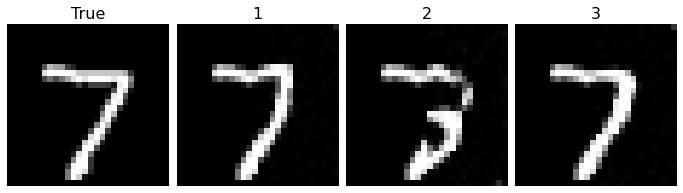

9


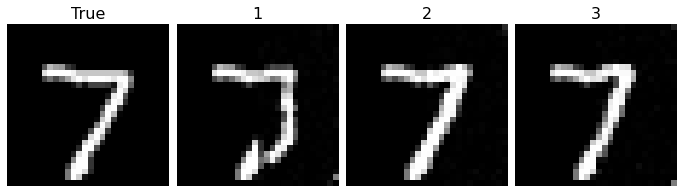

10


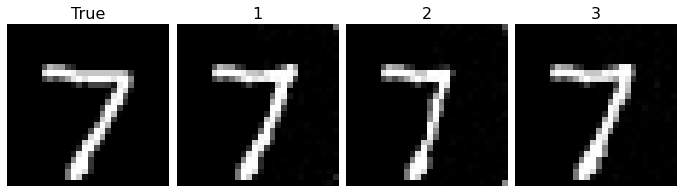

In [126]:
plot_experiment('seven',order)

1


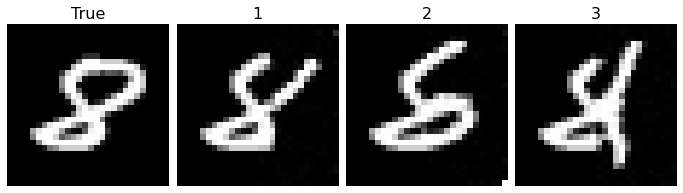

2


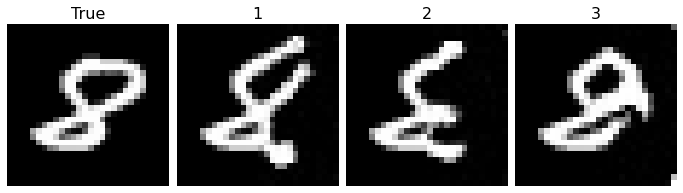

3


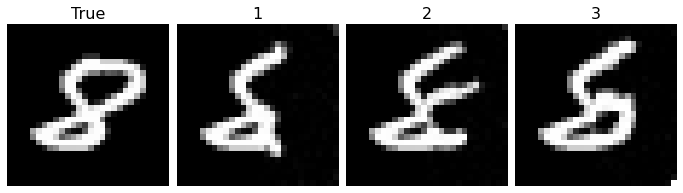

4


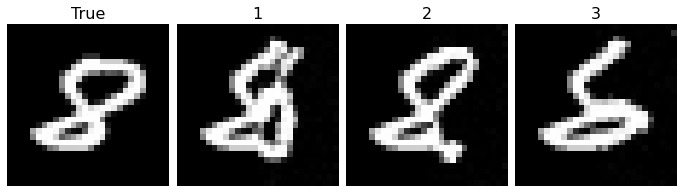

5


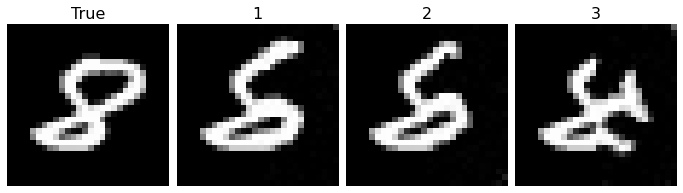

6


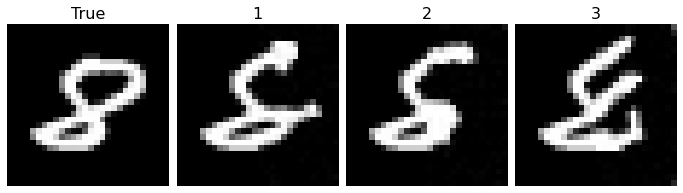

7


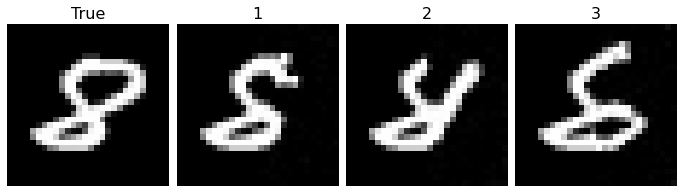

8


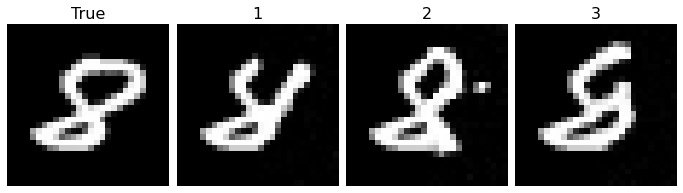

9


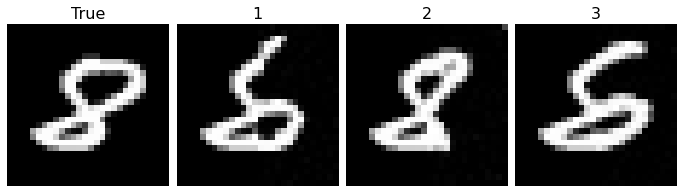

10


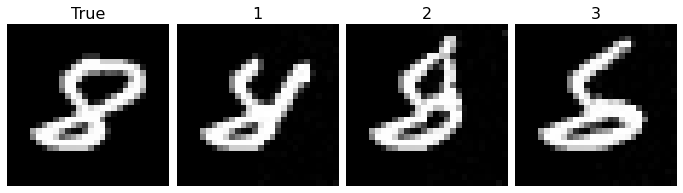

In [127]:
plot_experiment('eight',order)

1


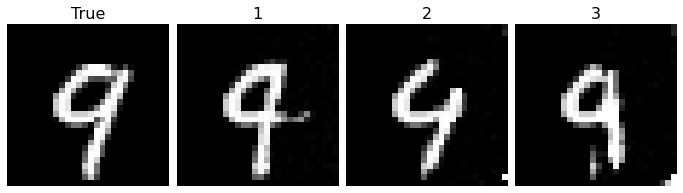

2


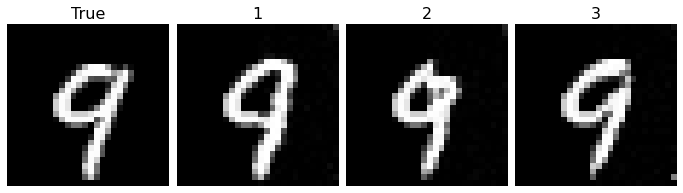

3


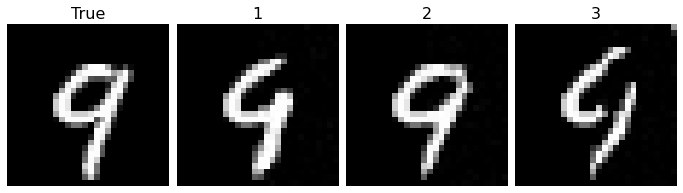

4


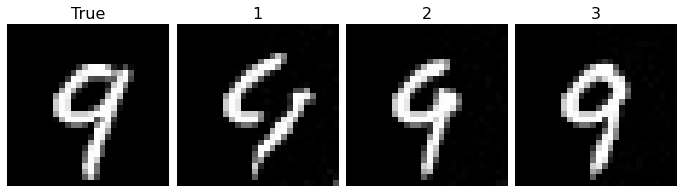

5


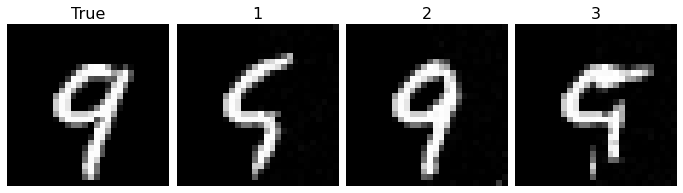

6


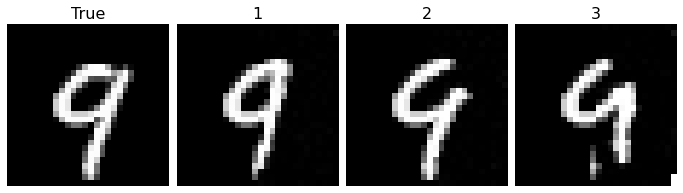

7


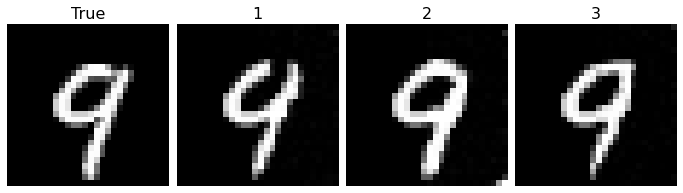

8


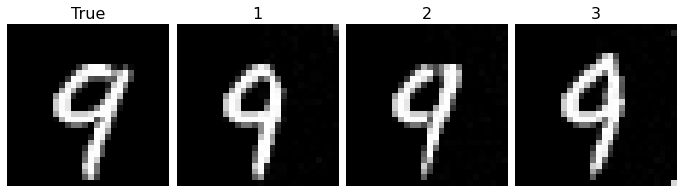

9


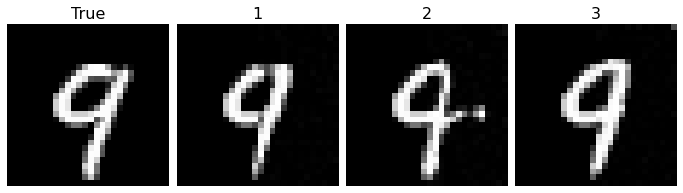

10


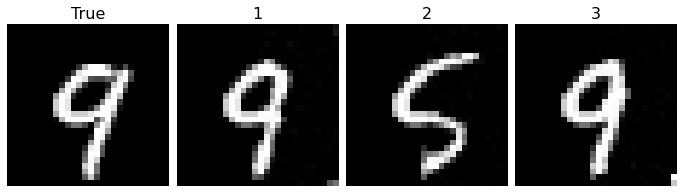

In [128]:
plot_experiment('nine',order)

In [114]:
order

array([[2, 0, 1],
       [2, 1, 0],
       [2, 0, 1],
       [1, 2, 0],
       [0, 2, 1],
       [0, 2, 1],
       [0, 2, 1],
       [2, 1, 0],
       [1, 2, 0],
       [2, 1, 0]])

# Experiment 2

In [134]:
test_data = MNIST('./data', train=True, transform=transforms.ToTensor())

In [135]:
random_samples = []
num=0
for image, label in test_data:
    random_samples.append(image)
    
    num += 1
    if num >= 25:
        break

In [136]:
random_samples = torch.stack(random_samples)

In [137]:
random_samples.shape

torch.Size([25, 1, 28, 28])

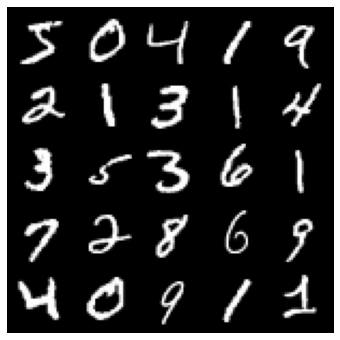

In [138]:
sample_grid = make_grid(random_samples, nrow=int(np.sqrt(25)))
plt.figure(figsize=(16,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0))
#plt.show()
plt.savefig('plots/MNIST_actual_samples.png', bbox_inches='tight', pad_inches=0.1)

In [173]:
idx = np.random.choice(2560, 25)

In [174]:
cde_samples = torch.load('data/MNIST_cde/cde_combined.pt', map_location=torch.device('cpu'))[idx]

In [175]:
cdiffe_samples = torch.load('data/MNIST_cdiffe/cdiffe_combined.pt', map_location=torch.device('cpu'))[idx]

In [176]:
smcdiff_samples = torch.load('data/MNIST_smcdiff_512/smcdiff_combined.pt', map_location=torch.device('cpu'))[idx]

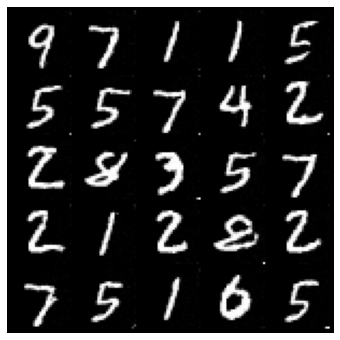

In [177]:
plt.figure(figsize=(16,6))
plt.axis('off')
plt.imshow(make_grid(smcdiff_samples, nrow=int(np.sqrt(25))).permute(1, 2, 0))

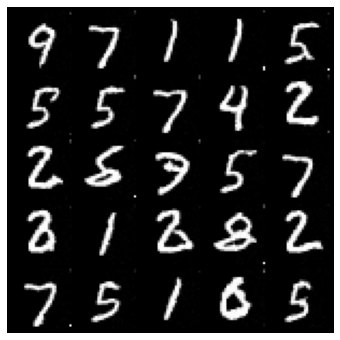

In [178]:
plt.figure(figsize=(16,6))
plt.axis('off')
plt.imshow(make_grid(cde_samples, nrow=int(np.sqrt(25))).permute(1, 2, 0))

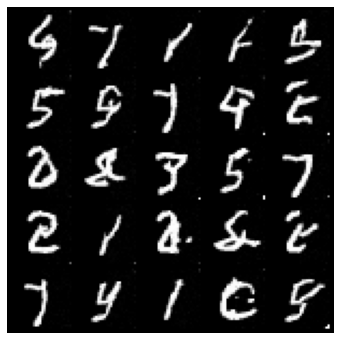

In [179]:
plt.figure(figsize=(16,6))
plt.axis('off')
plt.imshow(make_grid(cdiffe_samples, nrow=int(np.sqrt(25))).permute(1, 2, 0))

In [180]:
exp_2_samples = torch.cat([random_samples, cde_samples, cdiffe_samples, smcdiff_samples])

In [186]:
arrange = [0 for i in range(25)] + [1 for i in range(25)]+[2 for i in range(25)]+[3 for i in range(25)]

In [199]:
arrange = np.random.permutation(arrange)

In [196]:
def plot_experiment_2(images, order):

    true_n = 0
    cde_n = 0
    cdiffe_n = 0
    smc_n = 0
    
    for i in order:
        if i == 0:
            idx = true_n
            plt.imshow(images[idx][0], cmap = 'gray')
            true_n += 1
        elif i == 1:
            idx = 25 + cde_n
            plt.imshow(images[idx][0], cmap = 'gray')
            cde_n += 1
        elif i == 2:
            idx = 50 + cdiffe_n
            plt.imshow(images[idx][0], cmap = 'gray')
            cdiffe_n += 1
        else:
            idx = 75 + smc_n
            plt.imshow(images[idx][0], cmap = 'gray')
            smc_n += 1
        print(i)
        plt.show()

3


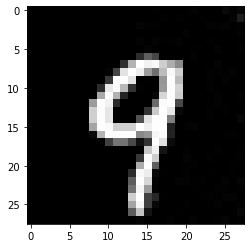

3


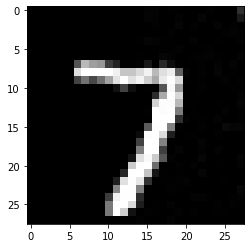

1


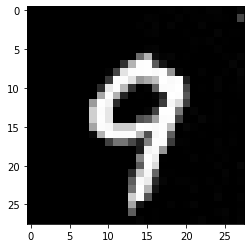

1


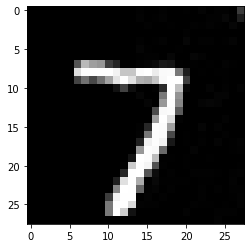

3


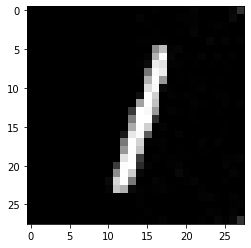

3


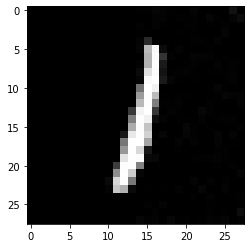

2


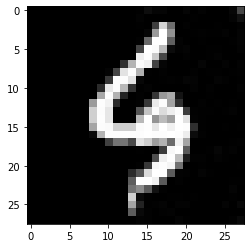

3


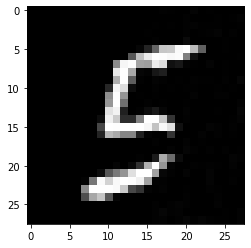

1


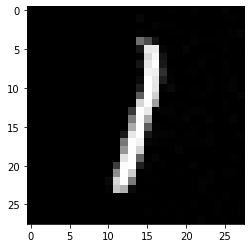

2


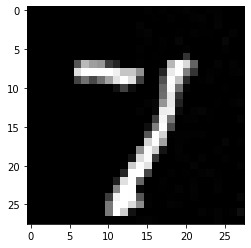

1


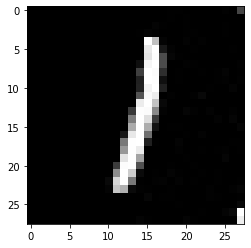

0


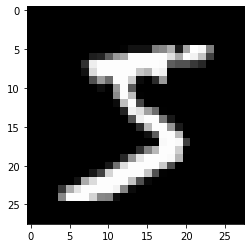

1


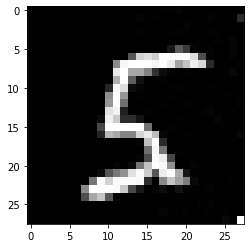

0


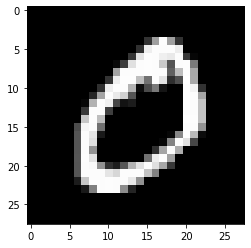

0


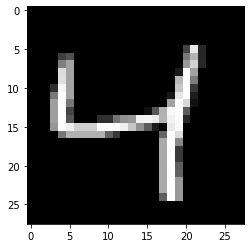

0


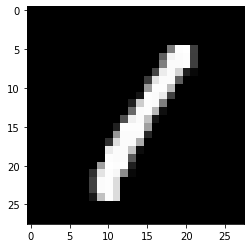

3


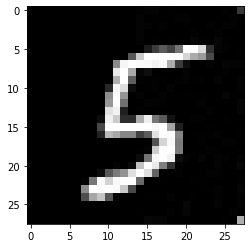

2


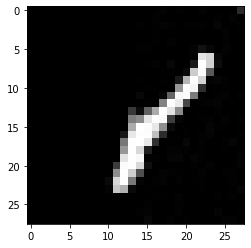

1


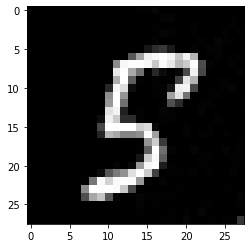

0


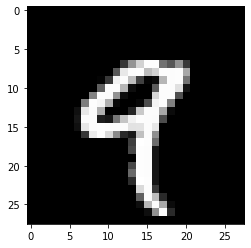

0


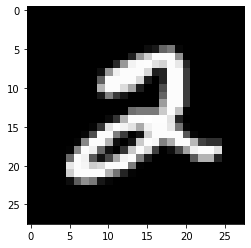

3


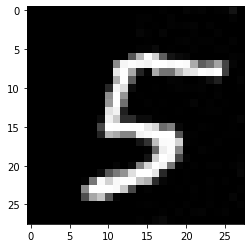

2


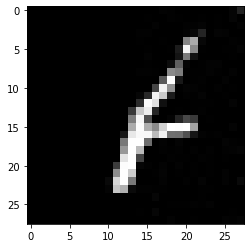

1


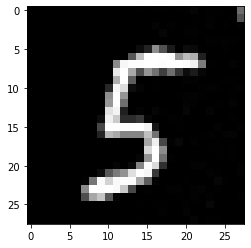

2


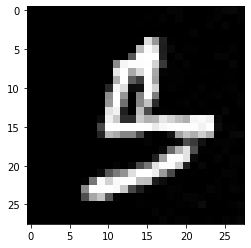

0


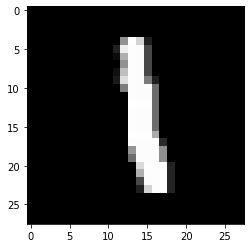

0


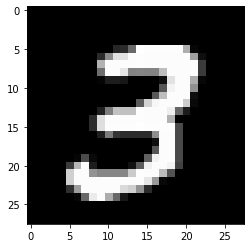

2


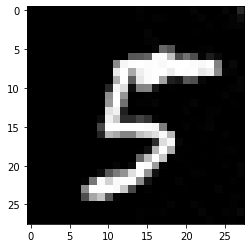

3


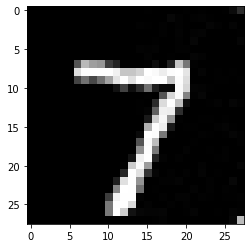

0


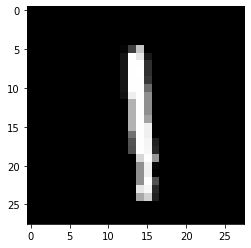

2


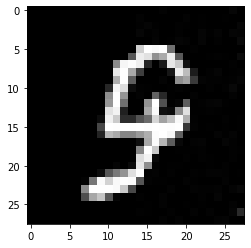

3


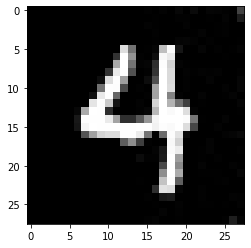

3


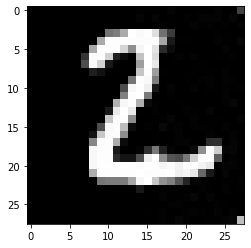

2


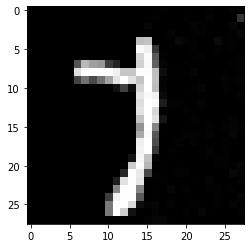

1


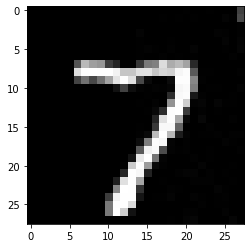

1


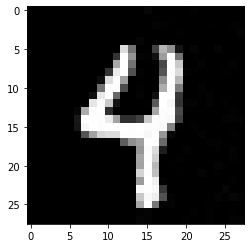

3


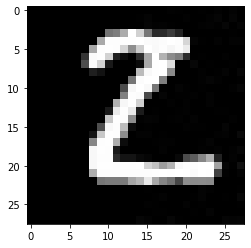

0


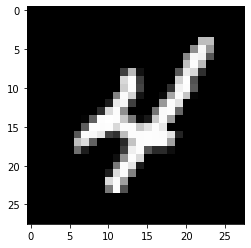

1


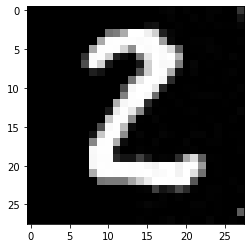

3


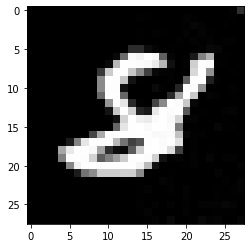

1


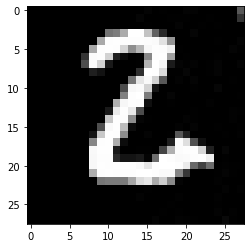

0


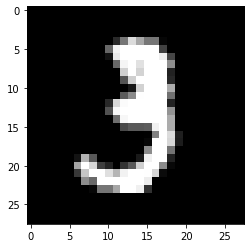

0


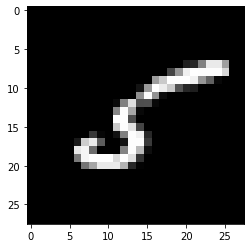

1


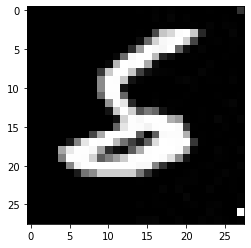

3


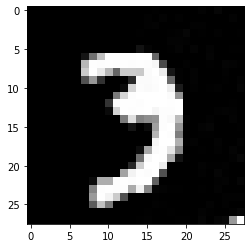

1


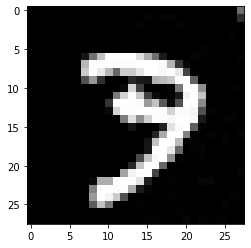

0


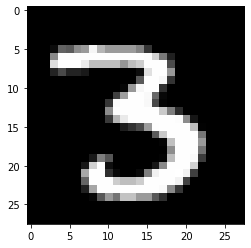

0


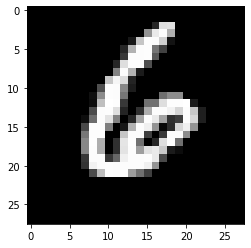

0


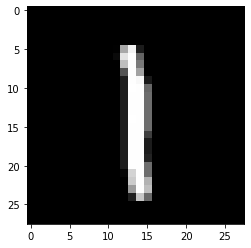

2


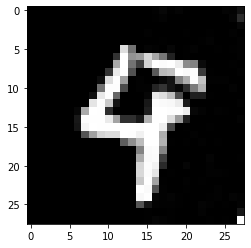

3


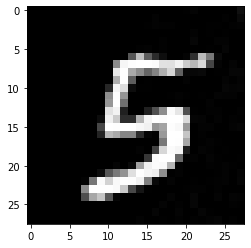

3


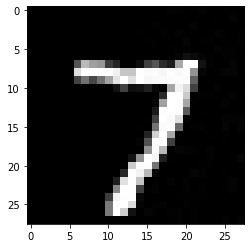

3


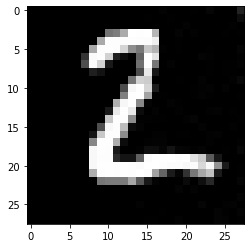

2


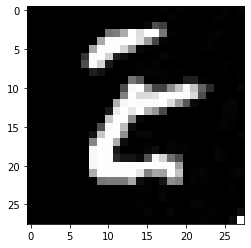

2


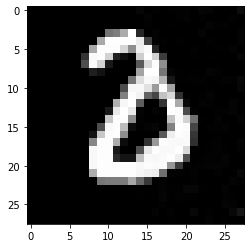

0


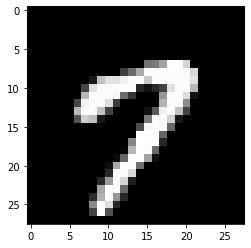

2


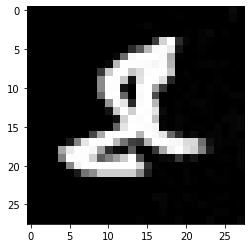

0


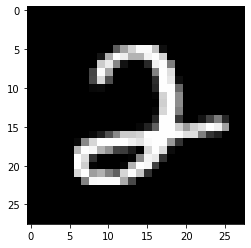

1


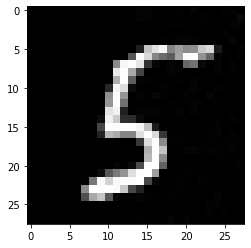

1


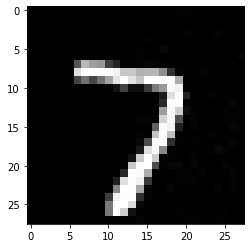

1


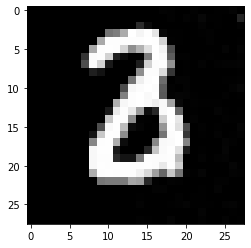

0


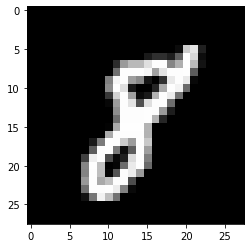

1


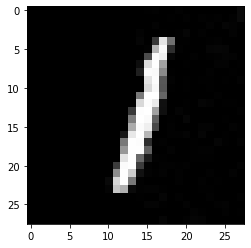

2


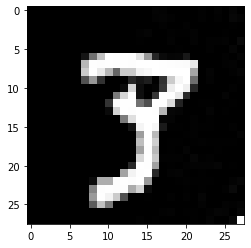

1


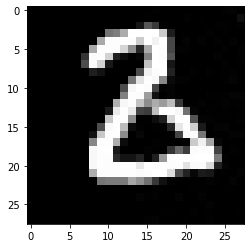

2


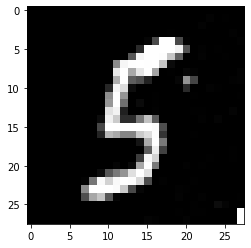

0


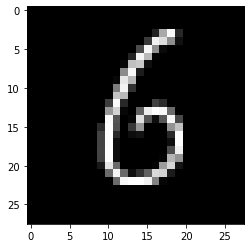

2


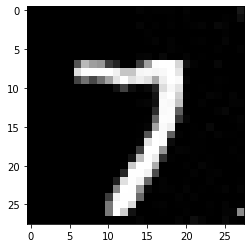

3


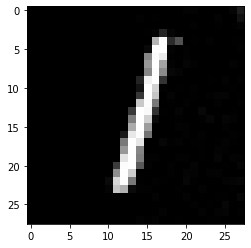

3


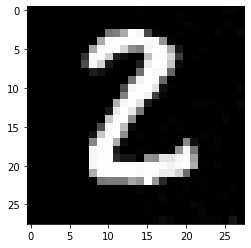

2


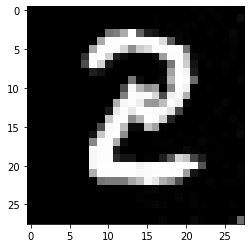

1


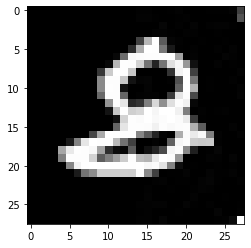

2


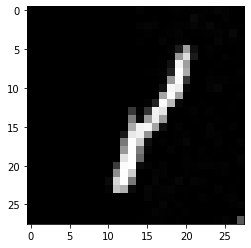

0


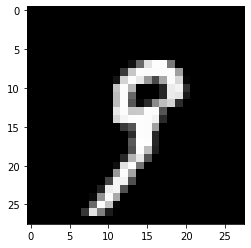

3


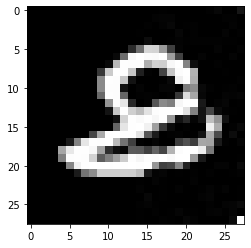

0


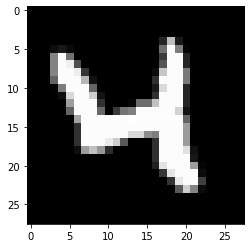

2


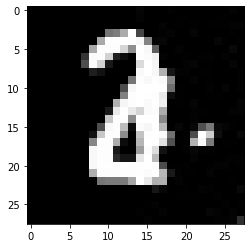

0


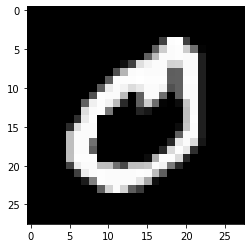

1


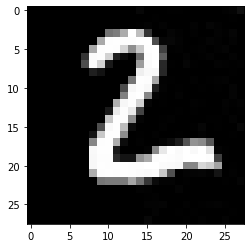

2


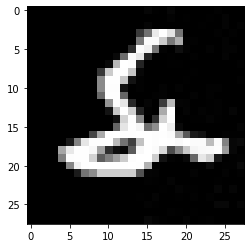

1


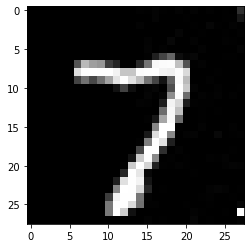

2


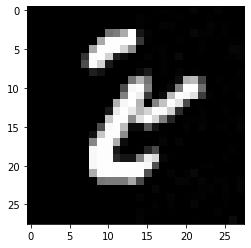

3


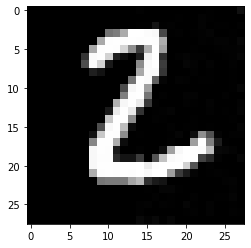

0


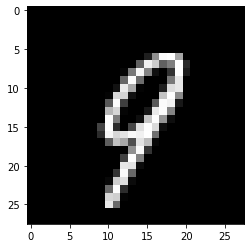

3


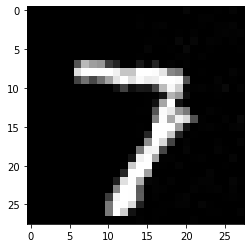

3


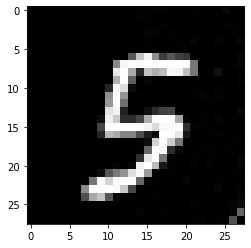

1


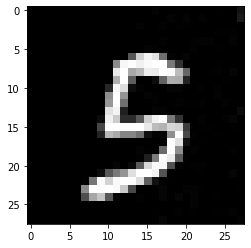

1


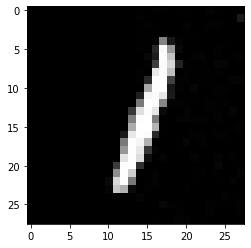

3


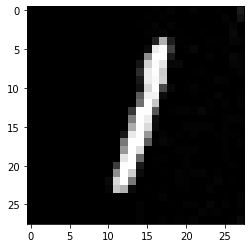

3


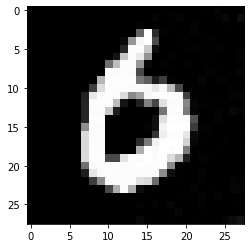

1


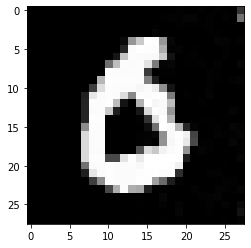

2


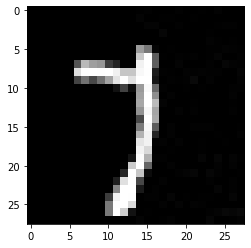

2


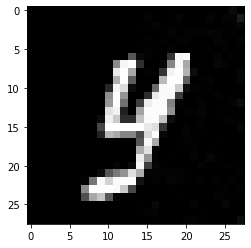

1


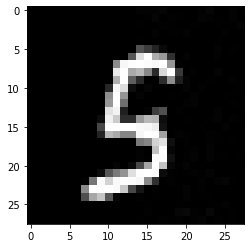

0


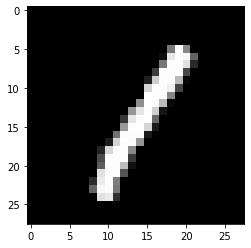

2


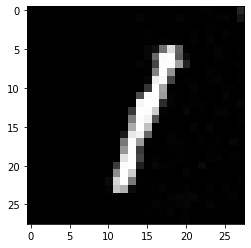

0


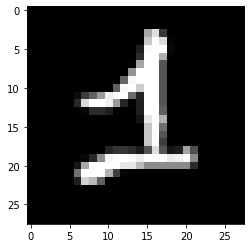

3


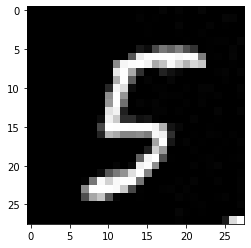

2


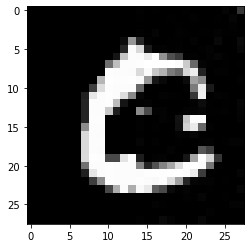

2


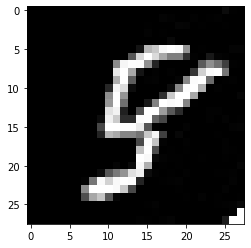

In [201]:
plot_experiment_2(exp_2_samples, arrange)

In [200]:
arrange

array([3, 3, 1, 1, 3, 3, 2, 3, 1, 2, 1, 0, 1, 0, 0, 0, 3, 2, 1, 0, 0, 3,
       2, 1, 2, 0, 0, 2, 3, 0, 2, 3, 3, 2, 1, 1, 3, 0, 1, 3, 1, 0, 0, 1,
       3, 1, 0, 0, 0, 2, 3, 3, 3, 2, 2, 0, 2, 0, 1, 1, 1, 0, 1, 2, 1, 2,
       0, 2, 3, 3, 2, 1, 2, 0, 3, 0, 2, 0, 1, 2, 1, 2, 3, 0, 3, 3, 1, 1,
       3, 3, 1, 2, 2, 1, 0, 2, 0, 3, 2, 2])